In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 2048
t_pra::Float64 = 0.0
filling::Float64 = 1.0
scale::Float64 = 0.1
#U::Float64 = 0.4 ##w=4
#U::Float64 = 0.2 ##w=2
#U::Float64 = 0.1 ##w=1
#function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
#    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
#end
#hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
U::Float64 = 0.5
hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)
;

In [8]:
# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [9]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

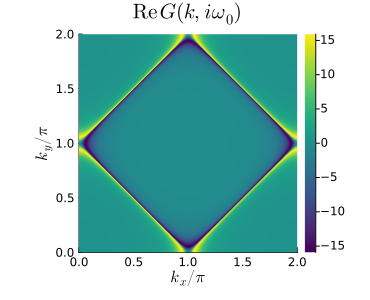

In [10]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

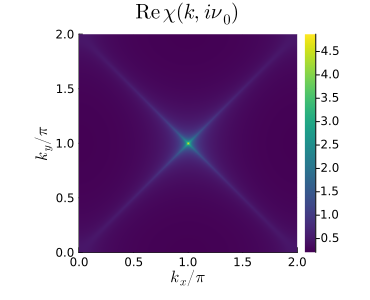

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [12]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

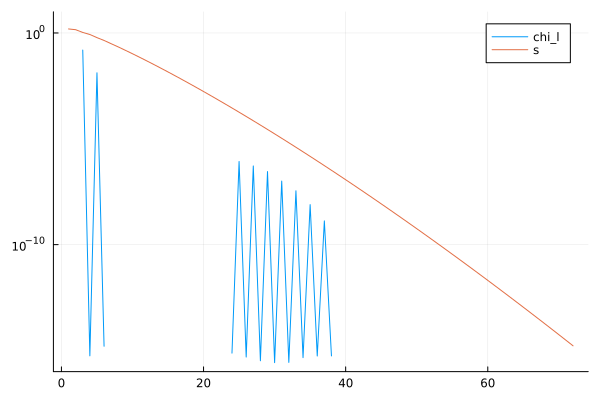

In [13]:
plot(yaxis=:log,ylims=(1e-16,10))
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

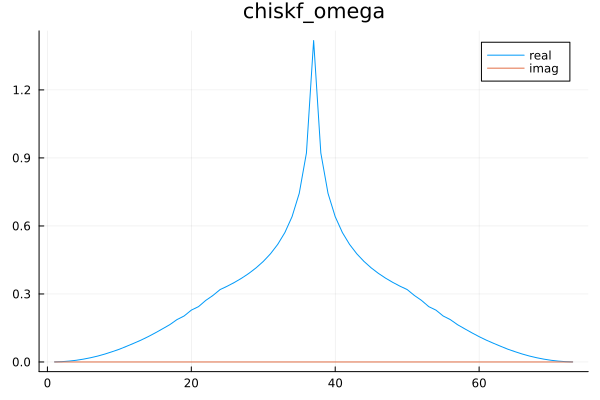

In [14]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

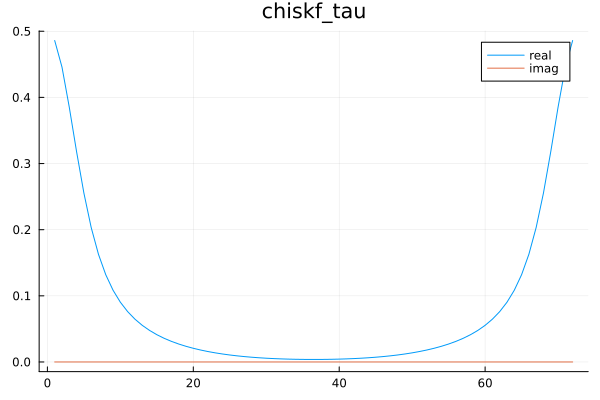

In [15]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [16]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

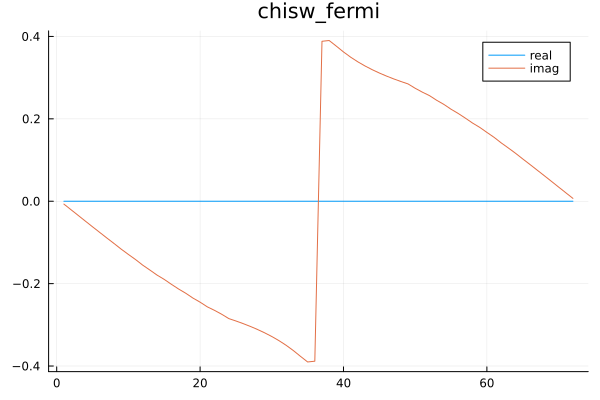

In [17]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [18]:
setprecision(512)

512

In [19]:
sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9923974467752623

In [20]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [21]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    #input_chi[i]  = 0.0 - im*imag(chisw[hnw+i])
    input_chi[i]  = - chisw[hnw+i]
end

In [22]:
N_real    =  6000
eta       =  0.01
omega_max =  8.0 + eta
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 10000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag    =  hnw
println("N_imag $(N_imag)")

N_imag is setted as 35
N_imag 35


In [23]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [24]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*π*(ix-1)/nsize
            ky::Float64 = 2*π*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq-lat.freemu,beta)-IRFLEX.fermi_dirac(ek-lat.freemu,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [25]:
exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max-eta, omega_max+eta, 1000))) .+ eta * im
#exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ 0.01 * im
exa_chi = exact_suscep(π,π,ComplexF64.(exa_freq),nsize,SparseIR.β(basis),hami)
;

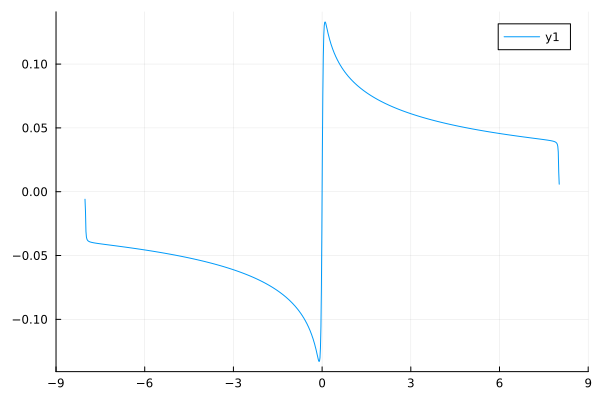

In [26]:
plot(xlim = [-9,9])
plot!(real.(exa_freq), imag.(exa_chi)/pi)

In [27]:
exa_chis = exa_chi ./ (1.0 .- lat.U*exa_chi)
;

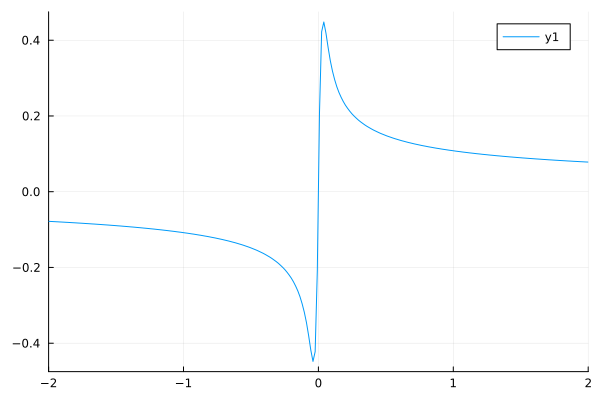

In [28]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chis)/pi)

In [29]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
#@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true, mesh=:log)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     2.683712e+00     4.260560e-01
 * time: 0.015331029891967773
     1     2.578608e+00     3.832341e-01
 * time: 1.66709303855896
     2     2.512118e+00     6.940165e-02
 * time: 3.89913010597229
     3     2.504913e+00     2.470916e-02
 * time: 5.164396047592163
     4     2.504730e+00     6.567871e-03
 * time: 6.036293029785156
     5     2.504707e+00     9.987018e-04
 * time: 6.9767420291900635
     6     2.504706e+00     4.488129e-04
 * time: 8.481073141098022
     7     2.504706e+00     1.843789e-04
 * time: 10.615005016326904
     8     2.504706e+00     2.952945e-05
 * time: 11.446077108383179
     9     2.504706e+00     1.915403e-05
 * time: 12.694899082183838
    10     2.504706e+00     3.499489e-06
 * time: 13.52918815612793
    11     2.504706e+00     1.011786e-06
 * time: 14.354984998703003
    12     2.504706e+00     3.892143e-07
 * time: 16.847641944885254
    13     2.504706e+00  

In [30]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     2.504706e+00     4.526499e-09
 * time: 0.00017786026000976562
max_theta=0.345441365976432460503527654417694591962419069610233500993945162341714362080718781643731444751650571525519122398246322126164811580375287633181937413425571289
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     2.504706e+00     5.375355e-01
 * time: 0.000186920166015625
     1     2.407950e+00     2.945630e-01
 * time: 2.176461935043335
     2     2.225781e+00     2.007471e-01
 * time: 3.108186960220337
     3     2.182066e+00     1.653856e-01
 * time: 5.45275092124939
     4     2.148480e+00     8.668517e-02
 * time: 9.010881900787354
     5     2.146504e+00     5.105886e-02
 * time: 9.944722890853882
     6     2.145144e+00     2.415308e-02
 * time: 10.881839990615845
     7     2.144961e+00     1.179249e-02
 * time: 12.006932020187378
     8     2.144919e+00     4.336698e-03
 * time: 13.072771072387695
     9     2.144907

    71     1.639876e+00     4.707929e-08
 * time: 97.5201530456543
    72     1.639876e+00     4.349851e-08
 * time: 99.73497700691223
    73     1.639876e+00     3.391157e-08
 * time: 100.77736496925354
    74     1.639876e+00     3.058292e-08
 * time: 101.81890392303467
    75     1.639876e+00     2.328411e-08
 * time: 102.86662197113037
    76     1.639876e+00     2.123060e-08
 * time: 103.91030406951904
    77     1.639876e+00     1.464963e-08
 * time: 105.11895394325256
    78     1.639876e+00     1.511463e-08
 * time: 107.32392406463623
    79     1.639876e+00     9.688438e-09
 * time: 108.50421905517578
max_theta=0.842309720821454467760419585246530237557986227338055985682521282710501553845201871229995217285469350324170094293752292542721649574180488063155892749172903372
hardy optimization was success.
H=4
Iter     Function value   Gradient norm 
     0     1.639876e+00     8.752356e-01
 * time: 0.00019097328186035156
     1     1.467291e+00     3.821433e-01
 * time: 1.18684291839

   108     1.094459e+00     1.134887e-07
 * time: 158.74129581451416
   109     1.094459e+00     1.207526e-07
 * time: 159.9057149887085
   110     1.094459e+00     9.683828e-08
 * time: 161.06266498565674
   111     1.094459e+00     9.337435e-08
 * time: 163.53956699371338
   112     1.094459e+00     7.724555e-08
 * time: 164.80932998657227
   113     1.094459e+00     7.734638e-08
 * time: 165.97839283943176
   114     1.094459e+00     5.831697e-08
 * time: 167.14833283424377
   115     1.094459e+00     6.326967e-08
 * time: 168.33468079566956
   116     1.094459e+00     4.726839e-08
 * time: 170.82973098754883
   117     1.094459e+00     4.830674e-08
 * time: 171.98748898506165
   118     1.094459e+00     3.642249e-08
 * time: 173.15018796920776
   119     1.094459e+00     3.625722e-08
 * time: 174.3196439743042
   120     1.094459e+00     2.667306e-08
 * time: 175.47562980651855
   121     1.094459e+00     3.012241e-08
 * time: 177.00275897979736
   122     1.094459e+00     1.946376

    93     6.414294e-01     1.069159e-06
 * time: 155.81054878234863
    94     6.414294e-01     1.331931e-06
 * time: 158.5723159313202
    95     6.414294e-01     8.929362e-07
 * time: 159.84920692443848
    96     6.414294e-01     1.095144e-06
 * time: 161.1408507823944
    97     6.414294e-01     7.457423e-07
 * time: 162.4480209350586
    98     6.414294e-01     8.545348e-07
 * time: 163.87010598182678
    99     6.414294e-01     6.087367e-07
 * time: 166.38066387176514
   100     6.414294e-01     6.551850e-07
 * time: 167.6737198829651
   101     6.414294e-01     4.864233e-07
 * time: 168.9696569442749
   102     6.414294e-01     5.639261e-07
 * time: 170.2622299194336
   103     6.414294e-01     4.091554e-07
 * time: 171.7063708305359
   104     6.414294e-01     5.128166e-07
 * time: 174.10954689979553
   105     6.414294e-01     3.239946e-07
 * time: 175.38466882705688
   106     6.414294e-01     4.324740e-07
 * time: 176.66749095916748
   107     6.414294e-01     2.684000e-07


    67     3.247619e-01     1.354054e-04
 * time: 128.96118211746216
    68     3.247619e-01     1.079382e-04
 * time: 130.50418305397034
    69     3.247619e-01     1.061215e-04
 * time: 133.7192120552063
    70     3.247619e-01     5.921549e-05
 * time: 135.09073495864868
    71     3.247619e-01     9.469752e-05
 * time: 137.1578221321106
    72     3.247619e-01     5.334325e-05
 * time: 138.6494541168213
    73     3.247619e-01     7.571076e-05
 * time: 141.82400393486023
    74     3.247618e-01     4.350809e-05
 * time: 143.27446794509888
    75     3.247618e-01     5.838979e-05
 * time: 145.3481240272522
    76     3.247618e-01     4.084351e-05
 * time: 147.8137309551239
    77     3.247618e-01     4.517416e-05
 * time: 149.87395000457764
    78     3.247618e-01     2.272549e-05
 * time: 151.25309801101685
    79     3.247618e-01     3.466168e-05
 * time: 153.34148907661438
    80     3.247618e-01     1.885946e-05
 * time: 155.93562412261963
    81     3.247618e-01     3.144745e-0

    36     1.488354e-01     5.885359e-04
 * time: 68.20556116104126
    37     1.488342e-01     1.062006e-03
 * time: 71.8005120754242
    38     1.488334e-01     4.940564e-04
 * time: 73.31166195869446
    39     1.488325e-01     8.359105e-04
 * time: 75.58801698684692
    40     1.488319e-01     2.918793e-04
 * time: 77.09701800346375
    41     1.488314e-01     5.930729e-04
 * time: 80.47500014305115
    42     1.488311e-01     2.608377e-04
 * time: 82.04358315467834
    43     1.488309e-01     3.273583e-04
 * time: 84.58225107192993
    44     1.488308e-01     3.028663e-04
 * time: 87.27920317649841
    45     1.488306e-01     2.557008e-04
 * time: 89.5441210269928
    46     1.488306e-01     1.686384e-04
 * time: 91.0616409778595
    47     1.488305e-01     2.539217e-04
 * time: 93.62381100654602
    48     1.488305e-01     1.378576e-04
 * time: 96.06492114067078
    49     1.488304e-01     1.676192e-04
 * time: 98.34294509887695
    50     1.488304e-01     1.255320e-04
 * time: 9

   156     1.488302e-01     4.935662e-08
 * time: 292.33178901672363
   157     1.488302e-01     5.949468e-08
 * time: 294.92832803726196
   158     1.488302e-01     3.959466e-08
 * time: 296.4436240196228
   159     1.488302e-01     4.896705e-08
 * time: 297.97762417793274
   160     1.488302e-01     3.162486e-08
 * time: 299.5036201477051
   161     1.488302e-01     4.025154e-08
 * time: 302.25211906433105
   162     1.488302e-01     2.787421e-08
 * time: 303.76556301116943
   163     1.488302e-01     3.333406e-08
 * time: 305.2781021595001
   164     1.488302e-01     2.447714e-08
 * time: 306.79428696632385
   165     1.488302e-01     2.783962e-08
 * time: 309.3788540363312
   166     1.488302e-01     2.120724e-08
 * time: 311.0090329647064
   167     1.488302e-01     2.337778e-08
 * time: 312.5187871456146
   168     1.488302e-01     1.861773e-08
 * time: 314.03149700164795
   169     1.488302e-01     1.968015e-08
 * time: 315.70265316963196
   170     1.488302e-01     1.547826e-08

    93     5.640307e-02     7.283804e-06
 * time: 186.55821990966797
    94     5.640307e-02     9.409462e-06
 * time: 188.1827850341797
    95     5.640307e-02     5.899611e-06
 * time: 189.83683490753174
    96     5.640307e-02     8.242912e-06
 * time: 191.46267294883728
    97     5.640307e-02     5.329581e-06
 * time: 194.20440196990967
    98     5.640307e-02     7.595606e-06
 * time: 195.83123588562012
    99     5.640307e-02     4.762835e-06
 * time: 197.46965193748474
   100     5.640307e-02     6.488103e-06
 * time: 199.37470984458923
   101     5.640307e-02     4.022857e-06
 * time: 202.19418597221375
   102     5.640307e-02     5.093946e-06
 * time: 203.82099604606628
   103     5.640307e-02     3.263488e-06
 * time: 205.44595384597778
   104     5.640307e-02     3.791148e-06
 * time: 207.07811498641968
   105     5.640307e-02     2.717312e-06
 * time: 209.9498209953308
   106     5.640307e-02     2.959224e-06
 * time: 211.60041689872742
   107     5.640307e-02     2.291046

    32     1.898535e-02     6.055994e-04
 * time: 87.04829788208008
    33     1.898195e-02     7.447030e-04
 * time: 88.78620505332947
    34     1.897966e-02     4.001686e-04
 * time: 90.70854210853577
    35     1.897808e-02     5.363623e-04
 * time: 92.54260110855103
    36     1.897702e-02     2.690798e-04
 * time: 95.5550799369812
    37     1.897618e-02     4.009830e-04
 * time: 97.29097509384155
    38     1.897554e-02     2.677219e-04
 * time: 99.03378510475159
    39     1.897500e-02     3.471282e-04
 * time: 101.06734299659729
    40     1.897459e-02     1.781385e-04
 * time: 103.86317706108093
    41     1.897424e-02     2.496100e-04
 * time: 105.64121389389038
    42     1.897392e-02     1.639882e-04
 * time: 107.38883805274963
    43     1.897360e-02     2.134854e-04
 * time: 110.29104495048523
    44     1.897331e-02     1.800566e-04
 * time: 112.03948593139648
    45     1.897302e-02     1.888947e-04
 * time: 113.82517004013062
    46     1.897277e-02     1.639971e-04
 

   152     1.897155e-02     6.990847e-08
 * time: 339.089026927948
   153     1.897155e-02     6.212340e-08
 * time: 341.1361849308014
   154     1.897155e-02     6.269618e-08
 * time: 343.98126006126404
   155     1.897155e-02     5.706087e-08
 * time: 345.7224578857422
   156     1.897155e-02     5.560839e-08
 * time: 347.48573088645935
   157     1.897155e-02     5.152914e-08
 * time: 349.49758791923523
   158     1.897155e-02     5.030300e-08
 * time: 352.28886008262634
   159     1.897155e-02     4.788183e-08
 * time: 354.0360429286957
   160     1.897155e-02     4.470098e-08
 * time: 355.7882239818573
   161     1.897155e-02     4.527201e-08
 * time: 358.6754059791565
   162     1.897155e-02     4.051320e-08
 * time: 360.5312569141388
   163     1.897155e-02     4.247354e-08
 * time: 362.2688400745392
   164     1.897155e-02     3.890503e-08
 * time: 364.0055420398712
   165     1.897155e-02     3.929334e-08
 * time: 367.1801528930664
   166     1.897155e-02     3.685370e-08
 * t

    84     7.858942e-03     9.407093e-07
 * time: 233.6195821762085
    85     7.858942e-03     8.253580e-07
 * time: 236.7446391582489
    86     7.858942e-03     8.794415e-07
 * time: 238.67487812042236
    87     7.858942e-03     7.157361e-07
 * time: 240.5487060546875
    88     7.858942e-03     7.633915e-07
 * time: 242.54046297073364
    89     7.858942e-03     5.812027e-07
 * time: 245.71757197380066
    90     7.858942e-03     6.086902e-07
 * time: 247.60198712348938
    91     7.858942e-03     5.027086e-07
 * time: 249.4821720123291
    92     7.858942e-03     4.668147e-07
 * time: 252.57813811302185
    93     7.858942e-03     5.095091e-07
 * time: 254.46944499015808
    94     7.858942e-03     4.036862e-07
 * time: 256.3799891471863
    95     7.858942e-03     4.785847e-07
 * time: 258.58903408050537
    96     7.858942e-03     3.242875e-07
 * time: 261.61782813072205
    97     7.858942e-03     3.966138e-07
 * time: 263.4891860485077
    98     7.858942e-03     2.759863e-07

    72     3.046568e-03     6.746980e-05
 * time: 227.8886170387268
    73     3.046533e-03     4.833301e-05
 * time: 230.85948991775513
    74     3.046507e-03     5.494976e-05
 * time: 232.87336707115173
    75     3.046475e-03     4.287926e-05
 * time: 237.33848810195923
    76     3.046451e-03     3.576391e-05
 * time: 239.44029307365417
    77     3.046425e-03     3.467447e-05
 * time: 243.6471619606018
    78     3.046406e-03     3.089916e-05
 * time: 245.64026999473572
    79     3.046386e-03     2.455538e-05
 * time: 248.8318419456482
    80     3.046371e-03     2.730027e-05
 * time: 252.20907592773438
    81     3.046356e-03     2.051088e-05
 * time: 255.18816709518433
    82     3.046345e-03     1.870997e-05
 * time: 257.17320799827576
    83     3.046334e-03     1.929775e-05
 * time: 260.5378029346466
    84     3.046326e-03     1.664317e-05
 * time: 262.5473449230194
    85     3.046319e-03     1.670347e-05
 * time: 264.5315680503845
    86     3.046313e-03     1.709429e-05

    48     1.204209e-03     9.480140e-05
 * time: 175.21494102478027
    49     1.203726e-03     1.097143e-04
 * time: 178.40329790115356
    50     1.203459e-03     1.252169e-04
 * time: 182.91121196746826
    51     1.203289e-03     9.896498e-05
 * time: 185.0196568965912
    52     1.203095e-03     1.080166e-04
 * time: 188.18821692466736
    53     1.202968e-03     9.514275e-05
 * time: 191.763121843338
    54     1.202720e-03     1.196082e-04
 * time: 195.14836597442627
    55     1.202540e-03     9.037440e-05
 * time: 197.28065490722656
    56     1.202180e-03     1.301371e-04
 * time: 201.66751098632812
    57     1.201969e-03     1.117507e-04
 * time: 203.82394289970398
    58     1.201385e-03     1.506587e-04
 * time: 207.30241894721985
    59     1.201294e-03     1.374099e-04
 * time: 210.58704781532288
    60     1.200850e-03     1.971543e-04
 * time: 213.74739384651184
    61     1.200194e-03     1.343696e-04
 * time: 218.39270186424255
    62     1.199928e-03     1.151430e

   168     1.194744e-03     4.126152e-07
 * time: 513.606568813324
   169     1.194744e-03     3.160752e-07
 * time: 516.7815999984741
   170     1.194744e-03     3.565389e-07
 * time: 518.8872239589691
   171     1.194744e-03     2.775489e-07
 * time: 521.1224849224091
   172     1.194744e-03     2.890538e-07
 * time: 524.6042289733887
   173     1.194744e-03     2.274829e-07
 * time: 526.7184770107269
   174     1.194744e-03     2.198754e-07
 * time: 528.8401079177856
   175     1.194744e-03     1.759397e-07
 * time: 532.253830909729
   176     1.194744e-03     1.557652e-07
 * time: 534.362744808197
   177     1.194744e-03     1.293903e-07
 * time: 536.6063709259033
   178     1.194743e-03     1.053703e-07
 * time: 539.1684868335724
   179     1.194743e-03     9.010560e-08
 * time: 542.2768950462341
   180     1.194743e-03     7.076587e-08
 * time: 544.4007329940796
   181     1.194743e-03     5.856230e-08
 * time: 546.5580489635468
   182     1.194743e-03     4.961904e-08
 * time: 5

    87     8.088123e-04     3.527273e-05
 * time: 298.80636405944824
    88     8.087699e-04     3.570431e-05
 * time: 302.3755929470062
    89     8.087224e-04     3.873527e-05
 * time: 306.74763894081116
    90     8.086628e-04     4.224930e-05
 * time: 310.5200140476227
    91     8.085998e-04     4.098833e-05
 * time: 315.16701102256775
    92     8.085268e-04     4.449814e-05
 * time: 318.5356910228729
    93     8.084579e-04     3.824799e-05
 * time: 322.16229796409607
    94     8.083857e-04     4.447481e-05
 * time: 324.40099596977234
    95     8.083209e-04     3.138513e-05
 * time: 326.64317202568054
    96     8.082583e-04     4.443802e-05
 * time: 330.2159221172333
    97     8.082002e-04     3.194569e-05
 * time: 332.5678081512451
    98     8.081461e-04     4.048158e-05
 * time: 334.801589012146
    99     8.080944e-04     3.444497e-05
 * time: 338.5356569290161
   100     8.080490e-04     3.376204e-05
 * time: 340.75872111320496
   101     8.080063e-04     3.573644e-05
 

   208     8.063070e-04     1.766631e-06
 * time: 651.5369400978088
   209     8.063069e-04     1.344060e-06
 * time: 653.766508102417
   210     8.063069e-04     1.600203e-06
 * time: 656.0017440319061
   211     8.063068e-04     1.273258e-06
 * time: 658.4967830181122
   212     8.063068e-04     1.441242e-06
 * time: 661.9862170219421
   213     8.063068e-04     1.198077e-06
 * time: 664.4244329929352
   214     8.063067e-04     1.285915e-06
 * time: 666.7166259288788
   215     8.063067e-04     1.161527e-06
 * time: 670.171147108078
   216     8.063067e-04     1.131400e-06
 * time: 672.451089143753
   217     8.063066e-04     1.120907e-06
 * time: 674.7461650371552
   218     8.063066e-04     1.074076e-06
 * time: 678.4922659397125
   219     8.063066e-04     1.044565e-06
 * time: 680.740473985672
   220     8.063065e-04     1.036993e-06
 * time: 682.9799139499664
   221     8.063065e-04     9.171046e-07
 * time: 686.65114402771
   222     8.063064e-04     9.738419e-07
 * time: 688.

    62     4.807106e-04     4.712661e-05
 * time: 245.19177293777466
    63     4.806629e-04     4.441803e-05
 * time: 248.80759406089783
    64     4.806343e-04     3.794943e-05
 * time: 252.2282838821411
    65     4.805985e-04     3.581459e-05
 * time: 255.73943495750427
    66     4.805547e-04     3.029657e-05
 * time: 260.44212102890015
    67     4.804768e-04     3.010898e-05
 * time: 263.977618932724
    68     4.803527e-04     3.831847e-05
 * time: 267.5964820384979
    69     4.802004e-04     3.914256e-05
 * time: 271.9687840938568
    70     4.800157e-04     3.652682e-05
 * time: 275.82946586608887
    71     4.799213e-04     4.298896e-05
 * time: 280.3531150817871
    72     4.798664e-04     3.832242e-05
 * time: 282.71521186828613
    73     4.798341e-04     3.276843e-05
 * time: 286.19220495224
    74     4.798096e-04     3.431261e-05
 * time: 289.86173701286316
    75     4.797884e-04     3.084372e-05
 * time: 294.3501789569855
    76     4.797610e-04     3.624251e-05
 * 

   183     4.725758e-04     1.389607e-07
 * time: 644.1928489208221
   184     4.725758e-04     1.086024e-07
 * time: 646.5719718933105
   185     4.725757e-04     8.481823e-08
 * time: 649.8984620571136
   186     4.725757e-04     6.875840e-08
 * time: 652.2764959335327
   187     4.725757e-04     5.652934e-08
 * time: 654.6217758655548
   188     4.725757e-04     4.375274e-08
 * time: 658.2158250808716
   189     4.725757e-04     3.680150e-08
 * time: 660.5462329387665
   190     4.725757e-04     2.682276e-08
 * time: 662.9365439414978
   191     4.725757e-04     1.986476e-08
 * time: 666.2418150901794
   192     4.725757e-04     1.430120e-08
 * time: 668.5870208740234
   193     4.725757e-04     1.003841e-08
 * time: 671.0451118946075
   194     4.725757e-04     6.687906e-09
 * time: 674.682345867157
max_theta=0.941978108716097857196775680606455426058361825783027850970895676814345360374699414950554981093929184843352871284890278780363509933238388366769785898822226812
hardy optimizati

   105     3.823206e-04     3.805247e-05
 * time: 445.7202489376068
   106     3.822582e-04     1.203645e-05
 * time: 449.34905195236206
   107     3.822439e-04     1.520158e-05
 * time: 451.94647884368896
   108     3.822397e-04     1.476818e-05
 * time: 455.8162729740143
   109     3.822377e-04     1.507845e-05
 * time: 460.63324189186096
   110     3.822341e-04     1.349189e-05
 * time: 464.4127359390259
   111     3.822276e-04     1.494113e-05
 * time: 469.36860489845276
   112     3.822179e-04     1.175109e-05
 * time: 473.19608092308044
   113     3.822061e-04     1.509792e-05
 * time: 476.97989797592163
   114     3.821917e-04     1.142906e-05
 * time: 479.5549387931824
   115     3.821759e-04     1.494104e-05
 * time: 482.1020178794861
   116     3.821565e-04     1.178218e-05
 * time: 487.01224088668823
   117     3.821356e-04     1.423423e-05
 * time: 489.53403878211975
   118     3.821116e-04     1.149582e-05
 * time: 494.5801239013672
   119     3.820863e-04     1.225079e-05

    57     3.392820e-04     7.857415e-05
 * time: 235.88133311271667
    58     3.390051e-04     8.366247e-05
 * time: 239.81814193725586
    59     3.382790e-04     9.238111e-05
 * time: 244.787339925766
    60     3.370018e-04     9.145492e-05
 * time: 248.71604299545288
    61     3.355700e-04     1.112581e-04
 * time: 253.97815608978271
    62     3.352806e-04     9.268819e-05
 * time: 256.59953713417053
    63     3.350794e-04     8.629918e-05
 * time: 261.86856293678284
    64     3.345996e-04     1.313746e-04
 * time: 265.7958149909973
    65     3.326113e-04     1.032719e-04
 * time: 272.27064990997314
    66     3.310715e-04     9.317148e-05
 * time: 276.44128608703613
    67     3.308402e-04     6.352070e-05
 * time: 280.1264250278473
    68     3.307737e-04     5.671232e-05
 * time: 284.24571800231934
    69     3.307277e-04     5.475893e-05
 * time: 289.40711307525635
    70     3.304500e-04     8.721029e-05
 * time: 294.6182150840759
    71     3.295458e-04     1.242011e-0

     3     3.237182e-04     5.126378e-04
 * time: 9.575998067855835
     4     3.234239e-04     5.325784e-04
 * time: 12.311186075210571
     5     3.230811e-04     4.269515e-04
 * time: 15.048025131225586
     6     3.226720e-04     3.499927e-04
 * time: 19.185095071792603
     7     3.222077e-04     3.001441e-04
 * time: 21.905498027801514
     8     3.216562e-04     2.666289e-04
 * time: 27.31574010848999
     9     3.211318e-04     2.267313e-04
 * time: 31.444281101226807
    10     3.204861e-04     2.428844e-04
 * time: 36.624094009399414
    11     3.198041e-04     2.154210e-04
 * time: 41.04469394683838
    12     3.189137e-04     2.053874e-04
 * time: 46.24684405326843
    13     3.178780e-04     2.691232e-04
 * time: 53.12848401069641
    14     3.169995e-04     5.225456e-04
 * time: 58.598856925964355
    15     3.163922e-04     3.133710e-04
 * time: 63.93143701553345
    16     3.148956e-04     2.118428e-04
 * time: 70.61795401573181
    17     3.140501e-04     2.200265e-04


   123     3.028431e-04     1.162947e-05
 * time: 583.2571160793304
   124     3.027960e-04     7.796100e-06
 * time: 587.3926389217377
   125     3.027839e-04     6.783463e-06
 * time: 591.405905008316
   126     3.027805e-04     7.038100e-06
 * time: 595.5703999996185
   127     3.027795e-04     6.794164e-06
 * time: 599.4782919883728
   128     3.027781e-04     7.103515e-06
 * time: 603.5971829891205
   129     3.027765e-04     6.938053e-06
 * time: 608.9415209293365
   130     3.027741e-04     6.790712e-06
 * time: 613.0398910045624
   131     3.027716e-04     7.097804e-06
 * time: 617.165060043335
   132     3.027685e-04     7.343058e-06
 * time: 621.3374760150909
   133     3.027653e-04     7.469670e-06
 * time: 624.0628910064697
   134     3.027607e-04     8.090199e-06
 * time: 629.1896231174469
   135     3.027558e-04     8.258882e-06
 * time: 632.27960896492
   136     3.027485e-04     8.992149e-06
 * time: 637.5220739841461
   137     3.027404e-04     9.220892e-06
 * time: 64

    55     2.930343e-04     1.311160e-05
 * time: 297.9926378726959
    56     2.930288e-04     1.108863e-05
 * time: 302.5080008506775
    57     2.930160e-04     1.233713e-05
 * time: 308.0437788963318
    58     2.929806e-04     7.988507e-06
 * time: 312.36313581466675
    59     2.929438e-04     1.050430e-05
 * time: 317.86305379867554
    60     2.929270e-04     8.956046e-06
 * time: 322.2281439304352
    61     2.929256e-04     8.775777e-06
 * time: 326.4440348148346
    62     2.929241e-04     8.625805e-06
 * time: 330.84628081321716
    63     2.929200e-04     8.574648e-06
 * time: 336.4524509906769
    64     2.929121e-04     7.814908e-06
 * time: 340.85898184776306
    65     2.928948e-04     6.621693e-06
 * time: 346.3490948677063
    66     2.928729e-04     5.145785e-06
 * time: 350.70270895957947
    67     2.928571e-04     4.605204e-06
 * time: 356.1001420021057
    68     2.928551e-04     4.229687e-06
 * time: 361.83456587791443
    69     2.928549e-04     4.340321e-06
 

   176     2.916424e-04     1.755077e-06
 * time: 857.551924943924
   177     2.916422e-04     1.747880e-06
 * time: 860.597363948822
   178     2.916421e-04     1.815425e-06
 * time: 864.7394759654999
   179     2.916419e-04     1.802858e-06
 * time: 867.8122148513794
   180     2.916417e-04     1.857032e-06
 * time: 870.9707489013672
   181     2.916415e-04     1.834910e-06
 * time: 875.1893389225006
   182     2.916413e-04     1.872190e-06
 * time: 878.1958978176117
   183     2.916411e-04     1.840222e-06
 * time: 882.6950259208679
   184     2.916409e-04     1.857617e-06
 * time: 885.861095905304
   185     2.916406e-04     1.813840e-06
 * time: 888.886885881424
   186     2.916404e-04     1.805178e-06
 * time: 893.0723450183868
   187     2.916401e-04     1.740670e-06
 * time: 896.2656519412994
   188     2.916398e-04     1.697229e-06
 * time: 899.284581899643
   189     2.916395e-04     1.597110e-06
 * time: 903.5644578933716
   190     2.916392e-04     1.506006e-06
 * time: 906

    86     2.888464e-04     9.887835e-07
 * time: 508.1525478363037
    87     2.888463e-04     1.047959e-06
 * time: 514.4063458442688
    88     2.888461e-04     1.281077e-06
 * time: 520.311057806015
    89     2.888450e-04     1.541645e-06
 * time: 525.3939478397369
    90     2.888438e-04     1.201859e-06
 * time: 531.2556250095367
    91     2.888416e-04     1.673860e-06
 * time: 537.4302928447723
    92     2.888406e-04     1.174687e-06
 * time: 542.1642038822174
    93     2.888405e-04     6.346084e-07
 * time: 548.2613809108734
    94     2.888405e-04     6.156420e-07
 * time: 551.4262228012085
    95     2.888404e-04     6.468183e-07
 * time: 557.2652268409729
    96     2.888404e-04     9.032702e-07
 * time: 563.9129610061646
    97     2.888403e-04     7.337768e-07
 * time: 568.2009928226471
    98     2.888402e-04     9.753023e-07
 * time: 572.906730890274
    99     2.888401e-04     7.975702e-07
 * time: 577.5379228591919
   100     2.888398e-04     6.594519e-07
 * time: 

   207     2.885748e-04     3.297389e-06
 * time: 1017.2978038787842
   208     2.885735e-04     3.127495e-06
 * time: 1021.8137838840485
   209     2.885722e-04     3.315325e-06
 * time: 1024.9249439239502
   210     2.885708e-04     3.133124e-06
 * time: 1028.0729508399963
   211     2.885694e-04     3.311269e-06
 * time: 1032.3833029270172
   212     2.885681e-04     3.119490e-06
 * time: 1035.5445017814636
   213     2.885667e-04     3.283101e-06
 * time: 1040.1794028282166
   214     2.885653e-04     3.084393e-06
 * time: 1043.3150107860565
   215     2.885639e-04     3.228676e-06
 * time: 1046.4339039325714
   216     2.885626e-04     3.025728e-06
 * time: 1050.985158920288
   217     2.885612e-04     3.146223e-06
 * time: 1054.0920958518982
   218     2.885600e-04     2.941929e-06
 * time: 1057.320532798767
   219     2.885587e-04     3.034583e-06
 * time: 1061.7877337932587
   220     2.885575e-04     2.831984e-06
 * time: 1064.942822933197
   221     2.885563e-04     2.893285e

    45     2.868859e-04     3.629533e-05
 * time: 281.6748859882355
    46     2.867617e-04     2.149598e-05
 * time: 288.0801320075989
    47     2.867187e-04     1.559392e-05
 * time: 292.9778048992157
    48     2.867071e-04     1.579386e-05
 * time: 299.10925698280334
    49     2.866996e-04     1.685491e-05
 * time: 304.1942799091339
    50     2.866784e-04     1.717711e-05
 * time: 310.4109480381012
    51     2.865012e-04     2.668840e-05
 * time: 318.323851108551
    52     2.863585e-04     1.266940e-05
 * time: 323.26854491233826
    53     2.862518e-04     2.131574e-05
 * time: 327.9509000778198
    54     2.862004e-04     1.633325e-05
 * time: 332.84815096855164
    55     2.861823e-04     1.666941e-05
 * time: 338.93248200416565
    56     2.861769e-04     1.537823e-05
 * time: 342.26090693473816
    57     2.861711e-04     1.388259e-05
 * time: 347.0295979976654
    58     2.861581e-04     1.603822e-05
 * time: 351.9427831172943
    59     2.861377e-04     1.399553e-05
 * 

   166     2.849711e-04     3.458335e-06
 * time: 852.349515914917
   167     2.849707e-04     3.481285e-06
 * time: 857.0277531147003
   168     2.849704e-04     3.552780e-06
 * time: 860.3849139213562
   169     2.849700e-04     3.564124e-06
 * time: 863.8181591033936
   170     2.849696e-04     3.618058e-06
 * time: 868.508898973465
   171     2.849692e-04     3.605243e-06
 * time: 871.9362499713898
   172     2.849688e-04     3.641864e-06
 * time: 876.658488035202
   173     2.849683e-04     3.618481e-06
 * time: 879.9114820957184
   174     2.849679e-04     3.645421e-06
 * time: 883.1833848953247
   175     2.849674e-04     3.622604e-06
 * time: 887.700933933258
   176     2.849669e-04     3.639447e-06
 * time: 890.987706899643
   177     2.849664e-04     3.612196e-06
 * time: 895.7736520767212
   178     2.849658e-04     3.611937e-06
 * time: 899.0664219856262
   179     2.849653e-04     3.569331e-06
 * time: 902.3164899349213
   180     2.849647e-04     3.546667e-06
 * time: 907

   286     2.848551e-04     1.576691e-06
 * time: 1344.3105840682983
   287     2.848547e-04     1.493594e-06
 * time: 1350.4711511135101
   288     2.848543e-04     1.659373e-06
 * time: 1356.5968630313873
   289     2.848535e-04     1.524606e-06
 * time: 1361.542545080185
   290     2.848517e-04     1.742687e-06
 * time: 1367.9751679897308
   291     2.848442e-04     1.450116e-06
 * time: 1375.9831800460815
   292     2.848433e-04     7.226976e-07
 * time: 1379.2634270191193
   293     2.848428e-04     5.464492e-07
 * time: 1385.6612269878387
   294     2.848426e-04     6.338108e-07
 * time: 1390.5590279102325
   295     2.848425e-04     7.027603e-07
 * time: 1395.1101949214935
   296     2.848425e-04     5.801706e-07
 * time: 1398.355803012848
   297     2.848425e-04     6.098895e-07
 * time: 1401.7850120067596
   298     2.848425e-04     5.554890e-07
 * time: 1408.0226879119873
   299     2.848425e-04     5.996144e-07
 * time: 1411.2710280418396
   300     2.848424e-04     5.346338

   406     2.848289e-04     6.053293e-07
 * time: 1852.2397150993347
   407     2.848288e-04     7.561977e-07
 * time: 1856.9845139980316
   408     2.848288e-04     6.288893e-07
 * time: 1860.2479650974274
   409     2.848288e-04     7.792856e-07
 * time: 1863.5237278938293
   410     2.848287e-04     6.542175e-07
 * time: 1868.064815044403
   411     2.848287e-04     8.046936e-07
 * time: 1871.3108839988708
   412     2.848286e-04     6.812831e-07
 * time: 1875.0684649944305
   413     2.848286e-04     8.324637e-07
 * time: 1879.374363899231
   414     2.848285e-04     7.100736e-07
 * time: 1882.6252920627594
   415     2.848285e-04     8.626921e-07
 * time: 1887.2846460342407
   416     2.848284e-04     7.406759e-07
 * time: 1890.5697131156921
   417     2.848284e-04     8.955367e-07
 * time: 1893.9954071044922
   418     2.848283e-04     7.732458e-07
 * time: 1898.564973115921
   419     2.848283e-04     9.311845e-07
 * time: 1901.8302609920502
   420     2.848282e-04     8.079166e

   526     2.846703e-04     6.790248e-06
 * time: 2353.1863169670105
   527     2.846645e-04     5.790896e-06
 * time: 2359.5163140296936
   528     2.846620e-04     6.460287e-06
 * time: 2362.8391721248627
   529     2.846548e-04     6.324438e-06
 * time: 2369.1524538993835
   530     2.846518e-04     7.029130e-06
 * time: 2372.414829969406
   531     2.846432e-04     6.468414e-06
 * time: 2378.6031908988953
   532     2.846398e-04     7.021884e-06
 * time: 2381.8787620067596
   533     2.846298e-04     5.756763e-06
 * time: 2388.3734419345856
   534     2.846258e-04     6.427998e-06
 * time: 2391.6389679908752
   535     2.846147e-04     4.555293e-06
 * time: 2397.9870080947876
   536     2.846099e-04     6.251008e-06
 * time: 2401.272066116333
   537     2.845981e-04     4.302979e-06
 * time: 2407.6652081012726
   538     2.845924e-04     5.589561e-06
 * time: 2410.933720111847
   539     2.845796e-04     5.574309e-06
 * time: 2417.0506598949432
   540     2.845718e-04     6.044340e

    35     2.837203e-04     3.822463e-05
 * time: 197.43197393417358
    36     2.837081e-04     2.909686e-05
 * time: 202.69352507591248
    37     2.836937e-04     2.517420e-05
 * time: 209.13051795959473
    38     2.836559e-04     2.764567e-05
 * time: 215.71023893356323
    39     2.836162e-04     3.251144e-05
 * time: 220.97486805915833
    40     2.835816e-04     3.429174e-05
 * time: 227.37171411514282
    41     2.835494e-04     4.205784e-05
 * time: 232.74162793159485
    42     2.835135e-04     3.627091e-05
 * time: 238.9374840259552
    43     2.834919e-04     2.577610e-05
 * time: 245.543555021286
    44     2.834205e-04     2.195876e-05
 * time: 250.6017119884491
    45     2.832374e-04     2.787978e-05
 * time: 257.29770493507385
    46     2.831494e-04     2.470453e-05
 * time: 262.40984296798706
    47     2.831415e-04     2.573255e-05
 * time: 267.1203579902649
    48     2.831295e-04     2.027159e-05
 * time: 272.4547200202942
    49     2.830887e-04     2.823681e-05

   156     2.809366e-04     1.323840e-05
 * time: 829.6071810722351
   157     2.809103e-04     1.450307e-05
 * time: 834.2190821170807
   158     2.808859e-04     1.214701e-05
 * time: 837.6002569198608
   159     2.808701e-04     1.209480e-05
 * time: 842.4544370174408
   160     2.808615e-04     1.064640e-05
 * time: 845.9779720306396
   161     2.808572e-04     1.062874e-05
 * time: 849.3771789073944
   162     2.808550e-04     1.010939e-05
 * time: 854.0499920845032
   163     2.808529e-04     9.844342e-06
 * time: 859.3925030231476
   164     2.808504e-04     1.003454e-05
 * time: 865.6776669025421
   165     2.808460e-04     9.058662e-06
 * time: 872.4058539867401
   166     2.808402e-04     9.364384e-06
 * time: 877.4993069171906
   167     2.808317e-04     8.146080e-06
 * time: 884.1619329452515
   168     2.808222e-04     8.860292e-06
 * time: 889.2780621051788
   169     2.808110e-04     7.481122e-06
 * time: 895.738429069519
   170     2.807994e-04     9.043338e-06
 * time:

   276     2.798276e-04     4.589460e-06
 * time: 1391.5968260765076
   277     2.798271e-04     6.379073e-06
 * time: 1395.023843050003
   278     2.798266e-04     4.736307e-06
 * time: 1399.7898080348969
   279     2.798261e-04     6.549661e-06
 * time: 1403.297905921936
   280     2.798256e-04     4.663765e-06
 * time: 1406.7869629859924
   281     2.798250e-04     6.705798e-06
 * time: 1411.376002073288
   282     2.798244e-04     4.670032e-06
 * time: 1414.860384941101
   283     2.798238e-04     6.685263e-06
 * time: 1419.717521905899
   284     2.798232e-04     4.696062e-06
 * time: 1423.0973830223083
   285     2.798226e-04     6.647106e-06
 * time: 1426.546415090561
   286     2.798221e-04     4.666326e-06
 * time: 1431.440565109253
   287     2.798214e-04     6.709361e-06
 * time: 1434.8320679664612
   288     2.798207e-04     4.603071e-06
 * time: 1439.5810329914093
   289     2.798200e-04     6.910047e-06
 * time: 1443.0493109226227
   290     2.798192e-04     4.575940e-06


   396     2.797314e-04     3.516850e-06
 * time: 1884.8155770301819
   397     2.797312e-04     4.523996e-06
 * time: 1889.4528050422668
   398     2.797311e-04     3.578803e-06
 * time: 1892.8476390838623
   399     2.797309e-04     4.570357e-06
 * time: 1899.592633008957
   400     2.797307e-04     3.641747e-06
 * time: 1903.0185720920563
   401     2.797305e-04     4.618652e-06
 * time: 1909.4802250862122
   402     2.797303e-04     3.704859e-06
 * time: 1913.1299409866333
   403     2.797301e-04     4.668646e-06
 * time: 1919.4021580219269
   404     2.797300e-04     3.766839e-06
 * time: 1922.8961780071259
   405     2.797297e-04     4.720010e-06
 * time: 1929.4573459625244
   406     2.797295e-04     3.827178e-06
 * time: 1932.8829929828644
   407     2.797293e-04     4.773457e-06
 * time: 1939.5025961399078
   408     2.797291e-04     3.885893e-06
 * time: 1942.8952040672302
   409     2.797288e-04     4.830182e-06
 * time: 1949.3501789569855
   410     2.797286e-04     3.94263

   516     2.796751e-04     1.227297e-06
 * time: 2389.684538125992
   517     2.796750e-04     1.513098e-06
 * time: 2393.439721107483
   518     2.796750e-04     1.243457e-06
 * time: 2398.127499103546
   519     2.796749e-04     1.542864e-06
 * time: 2401.560224056244
   520     2.796749e-04     1.260334e-06
 * time: 2406.4176800251007
   521     2.796748e-04     1.576533e-06
 * time: 2409.8706579208374
   522     2.796748e-04     1.278198e-06
 * time: 2413.3233680725098
   523     2.796747e-04     1.610868e-06
 * time: 2418.11648106575
   524     2.796747e-04     1.297109e-06
 * time: 2421.742917060852
   525     2.796746e-04     1.645897e-06
 * time: 2426.2996530532837
   526     2.796746e-04     1.316947e-06
 * time: 2429.6874289512634
   527     2.796745e-04     1.681568e-06
 * time: 2433.4277510643005
   528     2.796745e-04     1.337468e-06
 * time: 2438.1459970474243
   529     2.796744e-04     1.717758e-06
 * time: 2441.6297380924225
   530     2.796743e-04     1.358372e-06


   636     2.796658e-04     3.649691e-06
 * time: 2868.400239944458
   637     2.796657e-04     3.978204e-06
 * time: 2871.888256072998
   638     2.796656e-04     3.691858e-06
 * time: 2876.8516409397125
   639     2.796655e-04     4.020784e-06
 * time: 2880.2679600715637
   640     2.796654e-04     3.733867e-06
 * time: 2884.9957530498505
   641     2.796653e-04     4.063220e-06
 * time: 2888.4367339611053
   642     2.796652e-04     3.775711e-06
 * time: 2891.9473390579224
   643     2.796651e-04     4.105510e-06
 * time: 2896.4812519550323
   644     2.796650e-04     3.817384e-06
 * time: 2899.9316210746765
   645     2.796649e-04     4.147652e-06
 * time: 2904.805083990097
   646     2.796648e-04     3.858880e-06
 * time: 2908.2135269641876
   647     2.796647e-04     4.189645e-06
 * time: 2911.7309169769287
   648     2.796646e-04     3.900196e-06
 * time: 2916.561414003372
   649     2.796645e-04     4.231484e-06
 * time: 2919.994122982025
   650     2.796644e-04     3.941324e-0

   756     2.796528e-04     5.699597e-06
 * time: 3347.307303905487
   757     2.796527e-04     6.034448e-06
 * time: 3350.728775024414
   758     2.796526e-04     5.722244e-06
 * time: 3355.451020002365
   759     2.796525e-04     6.056182e-06
 * time: 3358.9410231113434
   760     2.796524e-04     5.744440e-06
 * time: 3363.5030019283295
   761     2.796523e-04     6.077437e-06
 * time: 3366.892599105835
   762     2.796522e-04     5.766187e-06
 * time: 3370.6270349025726
   763     2.796521e-04     6.098217e-06
 * time: 3375.381870031357
   764     2.796520e-04     5.787483e-06
 * time: 3378.908723115921
   765     2.796519e-04     6.118522e-06
 * time: 3383.7834289073944
   766     2.796518e-04     5.808327e-06
 * time: 3387.2083909511566
   767     2.796517e-04     6.138353e-06
 * time: 3390.607805967331
   768     2.796516e-04     5.828719e-06
 * time: 3395.5253269672394
   769     2.796515e-04     6.157710e-06
 * time: 3398.9504890441895
   770     2.796515e-04     5.848658e-06


   876     2.796438e-04     6.253186e-06
 * time: 3825.7787420749664
   877     2.796437e-04     6.537211e-06
 * time: 3829.229360103607
   878     2.796437e-04     6.248779e-06
 * time: 3833.8131980895996
   879     2.796436e-04     6.533178e-06
 * time: 3837.211177110672
   880     2.796435e-04     6.243931e-06
 * time: 3842.126513004303
   881     2.796435e-04     6.528799e-06
 * time: 3845.6098399162292
   882     2.796434e-04     6.238643e-06
 * time: 3849.138116121292
   883     2.796433e-04     6.524077e-06
 * time: 3853.892203092575
   884     2.796433e-04     6.232916e-06
 * time: 3857.3294670581818
   885     2.796432e-04     6.519016e-06
 * time: 3862.234976053238
   886     2.796432e-04     6.226749e-06
 * time: 3865.617471933365
   887     2.796431e-04     6.513622e-06
 * time: 3869.0155789852142
   888     2.796430e-04     6.220142e-06
 * time: 3873.7210750579834
   889     2.796430e-04     6.507898e-06
 * time: 3877.096296072006
   890     2.796429e-04     6.213096e-06
 

   997     2.796280e-04     5.877234e-06
 * time: 4307.727886915207
   998     2.796276e-04     5.528696e-06
 * time: 4312.424292087555
   999     2.796273e-04     5.900430e-06
 * time: 4315.963725090027
  1000     2.796269e-04     5.554006e-06
 * time: 4320.732865095139
  1001     2.796266e-04     5.922802e-06
 * time: 4324.171909093857
  1002     2.796262e-04     5.579547e-06
 * time: 4327.547873020172
  1003     2.796259e-04     5.944358e-06
 * time: 4332.323929071426
  1004     2.796255e-04     5.605319e-06
 * time: 4335.749360084534
  1005     2.796251e-04     5.965113e-06
 * time: 4340.387814044952
  1006     2.796248e-04     5.631325e-06
 * time: 4343.771610021591
  1007     2.796244e-04     5.985092e-06
 * time: 4347.41214799881
  1008     2.796240e-04     5.657569e-06
 * time: 4352.242202043533
  1009     2.796236e-04     6.004324e-06
 * time: 4355.786744117737
  1010     2.796233e-04     5.684056e-06
 * time: 4360.542834043503
  1011     2.796228e-04     6.022846e-06
 * time:

  1118     2.795158e-04     9.086586e-06
 * time: 4824.351294994354
  1119     2.795154e-04     9.758303e-06
 * time: 4829.123100042343
  1120     2.795151e-04     9.053004e-06
 * time: 4832.582718133926
  1121     2.795148e-04     9.664403e-06
 * time: 4835.942750930786
  1122     2.795146e-04     9.029489e-06
 * time: 4840.781976938248
  1123     2.795144e-04     9.601948e-06
 * time: 4844.18746304512
  1124     2.795141e-04     9.005112e-06
 * time: 4848.956967115402
  1125     2.795139e-04     9.560727e-06
 * time: 4852.339339017868
  1126     2.795137e-04     8.975422e-06
 * time: 4855.887442111969
  1127     2.795135e-04     9.527796e-06
 * time: 4860.757859945297
  1128     2.795133e-04     8.943263e-06
 * time: 4864.270575046539
  1129     2.795131e-04     9.495169e-06
 * time: 4869.023323059082
  1130     2.795129e-04     8.913246e-06
 * time: 4872.53752207756
  1131     2.795126e-04     9.460849e-06
 * time: 4875.899009943008
  1132     2.795124e-04     8.887268e-06
 * time: 

  1239     2.794630e-04     5.944292e-06
 * time: 5307.75124001503
  1240     2.794621e-04     6.436342e-06
 * time: 5311.128729104996
  1241     2.794612e-04     5.847367e-06
 * time: 5314.55783700943
  1242     2.794603e-04     6.377668e-06
 * time: 5319.283926010132
  1243     2.794594e-04     5.748960e-06
 * time: 5322.659353971481
  1244     2.794585e-04     6.318019e-06
 * time: 5327.475811004639
  1245     2.794576e-04     5.648884e-06
 * time: 5331.024833917618
  1246     2.794566e-04     6.257113e-06
 * time: 5334.476711988449
  1247     2.794557e-04     5.546975e-06
 * time: 5339.185796022415
  1248     2.794547e-04     6.194699e-06
 * time: 5342.7215440273285
  1249     2.794537e-04     5.443109e-06
 * time: 5347.498039960861
  1250     2.794528e-04     6.130578e-06
 * time: 5350.866693019867
  1251     2.794518e-04     5.337203e-06
 * time: 5354.311919927597
  1252     2.794508e-04     6.064620e-06
 * time: 5359.156898975372
  1253     2.794498e-04     5.229226e-06
 * time:

  1360     2.793318e-04     5.080937e-06
 * time: 5789.328926086426
  1361     2.793308e-04     5.914417e-06
 * time: 5792.7976360321045
  1362     2.793299e-04     5.087703e-06
 * time: 5797.763091087341
  1363     2.793290e-04     5.921210e-06
 * time: 5801.254251003265
  1364     2.793281e-04     5.093791e-06
 * time: 5805.983247041702
  1365     2.793271e-04     5.928724e-06
 * time: 5809.574542045593
  1366     2.793262e-04     5.099011e-06
 * time: 5812.9395089149475
  1367     2.793252e-04     5.936993e-06
 * time: 5817.68080997467
  1368     2.793243e-04     5.103093e-06
 * time: 5821.113441944122
  1369     2.793233e-04     5.945951e-06
 * time: 5825.871244907379
  1370     2.793224e-04     5.105670e-06
 * time: 5829.252408981323
  1371     2.793214e-04     5.955369e-06
 * time: 5832.669615030289
  1372     2.793204e-04     5.106252e-06
 * time: 5837.5183000564575
  1373     2.793194e-04     5.964772e-06
 * time: 5841.0142550468445
  1374     2.793184e-04     5.104200e-06
 * t

  1481     2.789061e-04     6.512519e-06
 * time: 6306.250754117966
  1482     2.789018e-04     4.255041e-06
 * time: 6309.768305063248
  1483     2.788979e-04     6.066741e-06
 * time: 6314.449548006058
  1484     2.788944e-04     3.539722e-06
 * time: 6318.033730983734
  1485     2.788913e-04     5.623564e-06
 * time: 6321.393013000488
  1486     2.788886e-04     3.166322e-06
 * time: 6326.103096961975
  1487     2.788863e-04     5.201551e-06
 * time: 6329.545687913895
  1488     2.788842e-04     3.142888e-06
 * time: 6334.325503110886
  1489     2.788824e-04     4.819166e-06
 * time: 6337.704895019531
  1490     2.788808e-04     3.127263e-06
 * time: 6341.126178979874
  1491     2.788795e-04     4.491163e-06
 * time: 6346.114615917206
  1492     2.788783e-04     3.119177e-06
 * time: 6349.606734991074
  1493     2.788772e-04     4.225940e-06
 * time: 6354.3218729496
  1494     2.788762e-04     3.117360e-06
 * time: 6357.952328920364
  1495     2.788753e-04     4.024567e-06
 * time: 

  1602     2.788164e-04     3.819103e-06
 * time: 6788.111027956009
  1603     2.788161e-04     3.989621e-06
 * time: 6792.869589090347
  1604     2.788158e-04     3.829289e-06
 * time: 6796.241712093353
  1605     2.788155e-04     3.971636e-06
 * time: 6799.656059026718
  1606     2.788152e-04     3.839546e-06
 * time: 6804.372654914856
  1607     2.788149e-04     3.956216e-06
 * time: 6807.749442100525
  1608     2.788146e-04     3.849958e-06
 * time: 6812.773291110992
  1609     2.788143e-04     3.944219e-06
 * time: 6816.282122135162
  1610     2.788140e-04     3.860555e-06
 * time: 6819.762535095215
  1611     2.788137e-04     3.936340e-06
 * time: 6824.532129049301
  1612     2.788134e-04     3.871320e-06
 * time: 6828.031762123108
  1613     2.788131e-04     3.933087e-06
 * time: 6832.863557100296
  1614     2.788128e-04     3.882200e-06
 * time: 6836.239300966263
  1615     2.788125e-04     3.934773e-06
 * time: 6839.668044090271
  1616     2.788122e-04     3.893120e-06
 * time

  1723     2.786996e-04     8.748918e-06
 * time: 7294.914756059647
  1724     2.786968e-04     9.501425e-06
 * time: 7298.27476811409
  1725     2.786940e-04     8.883807e-06
 * time: 7303.067898988724
  1726     2.786912e-04     9.655961e-06
 * time: 7306.502494096756
  1727     2.786886e-04     8.980335e-06
 * time: 7311.262404918671
  1728     2.786859e-04     9.825041e-06
 * time: 7314.6452651023865
  1729     2.786834e-04     9.092723e-06
 * time: 7318.166629076004
  1730     2.786810e-04     9.999612e-06
 * time: 7323.130620002747
  1731     2.786787e-04     9.227138e-06
 * time: 7326.622299909592
  1732     2.786764e-04     1.016568e-05
 * time: 7331.354145050049
  1733     2.786743e-04     9.369774e-06
 * time: 7334.972438097
  1734     2.786721e-04     1.032556e-05
 * time: 7338.338354110718
  1735     2.786701e-04     9.505951e-06
 * time: 7343.044102907181
  1736     2.786680e-04     1.048118e-05
 * time: 7346.496925115585
  1737     2.786659e-04     9.628835e-06
 * time: 7

  1844     2.771577e-04     1.315094e-05
 * time: 7825.308933973312
  1845     2.771211e-04     1.884466e-05
 * time: 7830.112210035324
  1846     2.770923e-04     1.083569e-05
 * time: 7833.685460090637
  1847     2.770690e-04     1.433691e-05
 * time: 7837.119117021561
  1848     2.770509e-04     8.697538e-06
 * time: 7841.810831069946
  1849     2.770360e-04     1.227279e-05
 * time: 7845.432714939117
  1850     2.770238e-04     8.354021e-06
 * time: 7850.153659105301
  1851     2.770131e-04     9.043866e-06
 * time: 7853.542742013931
  1852     2.770039e-04     7.089612e-06
 * time: 7857.051302909851
  1853     2.769952e-04     8.517463e-06
 * time: 7861.889437913895
  1854     2.769875e-04     6.067161e-06
 * time: 7865.274519920349
  1855     2.769798e-04     8.263148e-06
 * time: 7870.135710954666
  1856     2.769726e-04     5.745811e-06
 * time: 7873.718055963516
  1857     2.769653e-04     8.109180e-06
 * time: 7877.146291017532
  1858     2.769583e-04     5.566643e-06
 * time

  1965     2.767214e-04     1.009410e-06
 * time: 8309.051207065582
  1966     2.767213e-04     1.198141e-06
 * time: 8312.627815008163
  1967     2.767211e-04     9.759013e-07
 * time: 8315.986206054688
  1968     2.767210e-04     1.161167e-06
 * time: 8320.765949010849
  1969     2.767208e-04     9.425530e-07
 * time: 8324.20869398117
  1970     2.767207e-04     1.120886e-06
 * time: 8329.017585039139
  1971     2.767205e-04     9.093326e-07
 * time: 8332.40736413002
  1972     2.767204e-04     1.077637e-06
 * time: 8335.888688087463
  1973     2.767203e-04     8.762068e-07
 * time: 8340.869457960129
  1974     2.767201e-04     1.031674e-06
 * time: 8344.37582707405
  1975     2.767200e-04     8.431386e-07
 * time: 8349.11909198761
  1976     2.767199e-04     9.880850e-07
 * time: 8352.766479969025
  1977     2.767198e-04     8.100884e-07
 * time: 8356.162797927856
  1978     2.767197e-04     9.554508e-07
 * time: 8360.809864997864
  1979     2.767196e-04     7.770195e-07
 * time: 83

  2086     2.767172e-04     9.372170e-08
 * time: 8791.076630115509
  2087     2.767172e-04     1.259514e-07
 * time: 8794.539637088776
  2088     2.767172e-04     8.959433e-08
 * time: 8799.393149137497
  2089     2.767172e-04     1.172108e-07
 * time: 8802.766361951828
  2090     2.767172e-04     8.548290e-08
 * time: 8807.672811031342
  2091     2.767172e-04     1.083616e-07
 * time: 8811.233902931213
  2092     2.767172e-04     8.142855e-08
 * time: 8814.648325920105
  2093     2.767172e-04     9.951585e-08
 * time: 8819.310625076294
  2094     2.767172e-04     7.746484e-08
 * time: 8822.99840092659
  2095     2.767172e-04     9.079255e-08
 * time: 8827.55069899559
  2096     2.767172e-04     7.361672e-08
 * time: 8830.925226926804
  2097     2.767172e-04     8.231121e-08
 * time: 8834.514365911484
  2098     2.767172e-04     6.989976e-08
 * time: 8839.141969919205
  2099     2.767172e-04     7.418384e-08
 * time: 8842.511079072952
  2100     2.767172e-04     6.631995e-08
 * time: 

    12     2.763485e-04     1.064719e-04
 * time: 56.832719802856445
    13     2.762735e-04     8.969839e-05
 * time: 62.12329387664795
    14     2.761471e-04     9.310587e-05
 * time: 69.03499698638916
    15     2.760563e-04     8.370288e-05
 * time: 75.6711049079895
    16     2.758618e-04     8.549824e-05
 * time: 83.02121591567993
    17     2.757730e-04     6.773951e-05
 * time: 89.61447787284851
    18     2.756982e-04     9.126249e-05
 * time: 96.50754690170288
    19     2.755440e-04     6.685989e-05
 * time: 101.8007287979126
    20     2.754863e-04     5.663302e-05
 * time: 108.80262494087219
    21     2.754383e-04     5.710693e-05
 * time: 114.19694185256958
    22     2.753582e-04     7.223815e-05
 * time: 121.02767586708069
    23     2.752470e-04     7.837916e-05
 * time: 127.4219298362732
    24     2.750857e-04     7.737835e-05
 * time: 133.04720878601074
    25     2.749830e-04     6.826840e-05
 * time: 139.57367181777954
    26     2.748665e-04     7.109357e-05
 *

   133     2.723532e-04     3.714222e-05
 * time: 704.3998730182648
   134     2.723487e-04     2.840131e-05
 * time: 708.121780872345
   135     2.723414e-04     3.641474e-05
 * time: 714.6143238544464
   136     2.723358e-04     2.747398e-05
 * time: 718.3324530124664
   137     2.723278e-04     3.679527e-05
 * time: 725.042210817337
   138     2.723223e-04     2.905415e-05
 * time: 728.5813589096069
   139     2.723145e-04     3.103694e-05
 * time: 735.4640419483185
   140     2.723094e-04     2.338477e-05
 * time: 739.049852848053
   141     2.723011e-04     2.975086e-05
 * time: 745.665118932724
   142     2.722956e-04     2.252008e-05
 * time: 749.3146979808807
   143     2.722866e-04     2.293247e-05
 * time: 755.7693519592285
   144     2.722804e-04     1.629255e-05
 * time: 759.6256318092346
   145     2.722714e-04     2.451591e-05
 * time: 766.2273259162903
   146     2.722651e-04     2.365378e-05
 * time: 769.8429789543152
   147     2.722556e-04     2.861715e-05
 * time: 77

   254     2.718370e-04     1.355139e-05
 * time: 1321.9042148590088
   255     2.718334e-04     1.325103e-05
 * time: 1327.386281967163
   256     2.718313e-04     1.580621e-05
 * time: 1332.323618888855
   257     2.718280e-04     1.064671e-05
 * time: 1337.6391599178314
   258     2.718259e-04     1.093212e-05
 * time: 1342.5254499912262
   259     2.718231e-04     1.119574e-05
 * time: 1348.1759748458862
   260     2.718212e-04     1.416105e-05
 * time: 1352.9454078674316
   261     2.718189e-04     1.373868e-05
 * time: 1358.4584119319916
   262     2.718174e-04     1.543817e-05
 * time: 1363.347942829132
   263     2.718155e-04     1.281474e-05
 * time: 1370.001554965973
   264     2.718141e-04     1.276896e-05
 * time: 1373.531986951828
   265     2.718123e-04     1.417211e-05
 * time: 1380.23056101799
   266     2.718110e-04     1.580814e-05
 * time: 1383.7732808589935
   267     2.718092e-04     1.347287e-05
 * time: 1390.673089981079
   268     2.718077e-04     1.482745e-05
 

   374     2.714678e-04     1.830899e-05
 * time: 1928.9540939331055
   375     2.714637e-04     2.476937e-05
 * time: 1934.2792949676514
   376     2.714610e-04     1.885137e-05
 * time: 1939.4564008712769
   377     2.714564e-04     2.574665e-05
 * time: 1944.8429498672485
   378     2.714534e-04     2.029715e-05
 * time: 1949.765291929245
   379     2.714481e-04     2.545438e-05
 * time: 1955.231654882431
   380     2.714446e-04     2.061290e-05
 * time: 1959.9583599567413
   381     2.714387e-04     2.323535e-05
 * time: 1965.7171468734741
   382     2.714347e-04     1.905329e-05
 * time: 1970.366338968277
   383     2.714283e-04     1.877708e-05
 * time: 1975.9132158756256
   384     2.714243e-04     1.520865e-05
 * time: 1980.8001627922058
   385     2.714185e-04     1.252615e-05
 * time: 1987.504317998886
   386     2.714152e-04     1.131365e-05
 * time: 1991.0423879623413
   387     2.714104e-04     9.218762e-06
 * time: 1997.7055568695068
   388     2.714079e-04     1.363718e-

   494     2.713030e-04     9.180797e-06
 * time: 2467.1446390151978
   495     2.713027e-04     1.337094e-05
 * time: 2471.101599931717
   496     2.713023e-04     9.323501e-06
 * time: 2475.9233689308167
   497     2.713019e-04     1.336880e-05
 * time: 2479.490823984146
   498     2.713016e-04     9.354316e-06
 * time: 2484.606999874115
   499     2.713012e-04     1.328952e-05
 * time: 2488.1845688819885
   500     2.713008e-04     9.276468e-06
 * time: 2491.8679349422455
   501     2.713004e-04     1.314870e-05
 * time: 2496.7241928577423
   502     2.713001e-04     9.095894e-06
 * time: 2500.3658599853516
   503     2.712997e-04     1.296042e-05
 * time: 2505.0530688762665
   504     2.712993e-04     8.818283e-06
 * time: 2508.584610939026
   505     2.712989e-04     1.273758e-05
 * time: 2512.67777299881
   506     2.712985e-04     8.448711e-06
 * time: 2517.286866903305
   507     2.712981e-04     1.249430e-05
 * time: 2520.9144508838654
   508     2.712977e-04     7.992965e-06


   614     2.712475e-04     3.339879e-06
 * time: 2983.2132148742676
   615     2.712471e-04     7.628038e-06
 * time: 2986.772737979889
   616     2.712467e-04     3.433363e-06
 * time: 2991.8668558597565
   617     2.712464e-04     7.855562e-06
 * time: 2995.461261987686
   618     2.712460e-04     3.695586e-06
 * time: 3000.4648089408875
   619     2.712457e-04     8.003419e-06
 * time: 3004.035842895508
   620     2.712454e-04     3.968061e-06
 * time: 3007.6644690036774
   621     2.712451e-04     8.094646e-06
 * time: 3012.4529328346252
   622     2.712448e-04     4.238595e-06
 * time: 3016.121361017227
   623     2.712445e-04     8.148491e-06
 * time: 3021.2086567878723
   624     2.712442e-04     4.514907e-06
 * time: 3024.781986951828
   625     2.712440e-04     8.179172e-06
 * time: 3028.4494178295135
   626     2.712438e-04     4.798017e-06
 * time: 3033.494129896164
   627     2.712435e-04     8.196535e-06
 * time: 3037.1512248516083
   628     2.712433e-04     5.081662e-06

   734     2.712161e-04     6.723239e-06
 * time: 3482.7406198978424
   735     2.712157e-04     6.578639e-06
 * time: 3487.8029158115387
   736     2.712154e-04     6.720420e-06
 * time: 3491.3574438095093
   737     2.712150e-04     6.510523e-06
 * time: 3495.028100967407
   738     2.712147e-04     6.655259e-06
 * time: 3500.062498807907
   739     2.712143e-04     6.367756e-06
 * time: 3503.7086629867554
   740     2.712140e-04     6.528108e-06
 * time: 3508.5765748023987
   741     2.712136e-04     6.154371e-06
 * time: 3512.1292469501495
   742     2.712133e-04     6.341533e-06
 * time: 3515.776879787445
   743     2.712129e-04     5.876333e-06
 * time: 3520.4597058296204
   744     2.712126e-04     6.100066e-06
 * time: 3524.173565864563
   745     2.712122e-04     5.541024e-06
 * time: 3529.097790002823
   746     2.712118e-04     5.809914e-06
 * time: 3532.7112259864807
   747     2.712115e-04     5.156776e-06
 * time: 3537.736074924469
   748     2.712111e-04     5.478649e-06

   854     2.711720e-04     8.677883e-06
 * time: 3981.3168199062347
   855     2.711716e-04     1.027308e-05
 * time: 3985.932370901108
   856     2.711712e-04     8.520460e-06
 * time: 3989.730600833893
   857     2.711709e-04     9.962234e-06
 * time: 3994.6053059101105
   858     2.711705e-04     8.129061e-06
 * time: 3998.2073237895966
   859     2.711702e-04     9.429710e-06
 * time: 4003.2961678504944
   860     2.711699e-04     7.583946e-06
 * time: 4006.9654059410095
   861     2.711696e-04     9.671759e-06
 * time: 4010.5786888599396
   862     2.711694e-04     6.964326e-06
 * time: 4015.5284399986267
   863     2.711691e-04     9.986044e-06
 * time: 4019.1025018692017
   864     2.711688e-04     6.966076e-06
 * time: 4024.042237997055
   865     2.711685e-04     1.025376e-05
 * time: 4027.575690984726
   866     2.711682e-04     7.010490e-06
 * time: 4031.353236913681
   867     2.711679e-04     1.043860e-05
 * time: 4036.2943139076233
   868     2.711676e-04     6.960594e-0

   975     2.711424e-04     2.876879e-06
 * time: 4484.872770786285
   976     2.711423e-04     4.646175e-06
 * time: 4489.7256507873535
   977     2.711422e-04     2.778684e-06
 * time: 4493.251255989075
   978     2.711421e-04     4.519673e-06
 * time: 4497.125595808029
   979     2.711421e-04     2.664268e-06
 * time: 4501.938724994659
   980     2.711420e-04     4.358656e-06
 * time: 4505.5760979652405
   981     2.711419e-04     2.545838e-06
 * time: 4510.507438898087
   982     2.711418e-04     4.173686e-06
 * time: 4514.217146873474
   983     2.711418e-04     2.433415e-06
 * time: 4517.8396899700165
   984     2.711417e-04     3.978383e-06
 * time: 4522.5897698402405
   985     2.711417e-04     2.332372e-06
 * time: 4526.140522956848
   986     2.711416e-04     3.788090e-06
 * time: 4531.039430856705
   987     2.711416e-04     2.242165e-06
 * time: 4534.554579973221
   988     2.711415e-04     3.617696e-06
 * time: 4539.544142007828
   989     2.711415e-04     2.157437e-06
 * 

  1096     2.711307e-04     3.127771e-06
 * time: 4988.181862831116
  1097     2.711306e-04     2.597770e-06
 * time: 4991.718425989151
  1098     2.711306e-04     2.935917e-06
 * time: 4996.564759969711
  1099     2.711305e-04     2.403753e-06
 * time: 5000.080412864685
  1100     2.711304e-04     2.741392e-06
 * time: 5005.161388874054
  1101     2.711304e-04     2.209882e-06
 * time: 5008.785018920898
  1102     2.711303e-04     2.545843e-06
 * time: 5012.408806800842
  1103     2.711303e-04     2.018138e-06
 * time: 5017.406854867935
  1104     2.711302e-04     2.350869e-06
 * time: 5021.106438875198
  1105     2.711302e-04     1.830319e-06
 * time: 5026.008042812347
  1106     2.711301e-04     2.157991e-06
 * time: 5029.527554988861
  1107     2.711301e-04     1.647998e-06
 * time: 5033.088229894638
  1108     2.711300e-04     1.968615e-06
 * time: 5038.092688798904
  1109     2.711300e-04     1.472516e-06
 * time: 5041.597315788269
  1110     2.711299e-04     1.784013e-06
 * time

  1217     2.711268e-04     2.037312e-06
 * time: 5491.504015922546
  1218     2.711268e-04     2.238875e-06
 * time: 5495.027729988098
  1219     2.711268e-04     2.151797e-06
 * time: 5498.597887992859
  1220     2.711268e-04     2.363068e-06
 * time: 5503.531700849533
  1221     2.711267e-04     2.266301e-06
 * time: 5507.0364809036255
  1222     2.711267e-04     2.489341e-06
 * time: 5512.179060935974
  1223     2.711267e-04     2.380285e-06
 * time: 5515.839010000229
  1224     2.711267e-04     2.617140e-06
 * time: 5519.427462816238
  1225     2.711266e-04     2.493159e-06
 * time: 5524.48718380928
  1226     2.711266e-04     2.745715e-06
 * time: 5528.072565793991
  1227     2.711266e-04     2.604284e-06
 * time: 5532.863727807999
  1228     2.711266e-04     2.874153e-06
 * time: 5536.433403015137
  1229     2.711265e-04     2.712996e-06
 * time: 5540.132257938385
  1230     2.711265e-04     3.001453e-06
 * time: 5544.9094388484955
  1231     2.711265e-04     2.818639e-06
 * tim

  1338     2.711196e-04     4.331902e-06
 * time: 5993.9305918216705
  1339     2.711195e-04     4.453106e-06
 * time: 5998.759436845779
  1340     2.711194e-04     4.243073e-06
 * time: 6002.33210682869
  1341     2.711193e-04     4.387644e-06
 * time: 6005.993016004562
  1342     2.711192e-04     4.153713e-06
 * time: 6010.729497909546
  1343     2.711192e-04     4.318705e-06
 * time: 6014.344297885895
  1344     2.711191e-04     4.064071e-06
 * time: 6019.35563993454
  1345     2.711190e-04     4.246440e-06
 * time: 6023.007915973663
  1346     2.711189e-04     3.974368e-06
 * time: 6027.9220089912415
  1347     2.711188e-04     4.171000e-06
 * time: 6031.712879896164
  1348     2.711187e-04     3.884801e-06
 * time: 6035.24171090126
  1349     2.711186e-04     4.092547e-06
 * time: 6040.139938831329
  1350     2.711186e-04     3.795544e-06
 * time: 6043.752887964249
  1351     2.711185e-04     4.011247e-06
 * time: 6048.749790906906
  1352     2.711184e-04     3.706749e-06
 * time:

  1459     2.711113e-04     2.000941e-06
 * time: 6497.132608890533
  1460     2.711112e-04     2.182256e-06
 * time: 6500.713537931442
  1461     2.711112e-04     2.004870e-06
 * time: 6505.661728858948
  1462     2.711112e-04     2.184409e-06
 * time: 6509.241833925247
  1463     2.711111e-04     2.008892e-06
 * time: 6514.142056941986
  1464     2.711111e-04     2.186715e-06
 * time: 6517.6647799015045
  1465     2.711111e-04     2.013032e-06
 * time: 6521.456789970398
  1466     2.711110e-04     2.189165e-06
 * time: 6526.42462682724
  1467     2.711110e-04     2.017316e-06
 * time: 6530.045783996582
  1468     2.711110e-04     2.191752e-06
 * time: 6534.955902814865
  1469     2.711109e-04     2.021774e-06
 * time: 6538.734272956848
  1470     2.711109e-04     2.194466e-06
 * time: 6542.307890892029
  1471     2.711108e-04     2.026439e-06
 * time: 6547.02378487587
  1472     2.711108e-04     2.197300e-06
 * time: 6550.665567874908
  1473     2.711108e-04     2.036585e-06
 * time:

  1580     2.711041e-04     3.897108e-06
 * time: 7000.542877912521
  1581     2.711040e-04     3.923224e-06
 * time: 7004.29726600647
  1582     2.711039e-04     3.967255e-06
 * time: 7007.869994878769
  1583     2.711038e-04     4.013034e-06
 * time: 7012.603524923325
  1584     2.711037e-04     4.037228e-06
 * time: 7016.164197921753
  1585     2.711036e-04     4.102023e-06
 * time: 7021.086979866028
  1586     2.711035e-04     4.106804e-06
 * time: 7024.6029307842255
  1587     2.711035e-04     4.189931e-06
 * time: 7029.570251941681
  1588     2.711034e-04     4.175763e-06
 * time: 7033.294961929321
  1589     2.711033e-04     4.276507e-06
 * time: 7036.855678796768
  1590     2.711032e-04     4.243894e-06
 * time: 7041.877813816071
  1591     2.711031e-04     4.361510e-06
 * time: 7045.6340589523315
  1592     2.711030e-04     4.310990e-06
 * time: 7050.51877784729
  1593     2.711029e-04     4.444714e-06
 * time: 7054.126103878021
  1594     2.711028e-04     4.376855e-06
 * time

  1701     2.710948e-04     5.352160e-06
 * time: 7503.178583860397
  1702     2.710948e-04     5.221038e-06
 * time: 7508.171165943146
  1703     2.710947e-04     5.344815e-06
 * time: 7511.951997995377
  1704     2.710947e-04     5.219144e-06
 * time: 7516.755678892136
  1705     2.710946e-04     5.338096e-06
 * time: 7520.284398794174
  1706     2.710946e-04     5.217679e-06
 * time: 7524.07204079628
  1707     2.710945e-04     5.331974e-06
 * time: 7529.008898973465
  1708     2.710945e-04     5.216614e-06
 * time: 7532.539062976837
  1709     2.710944e-04     5.326408e-06
 * time: 7537.667145013809
  1710     2.710944e-04     5.215912e-06
 * time: 7541.302711963654
  1711     2.710943e-04     5.321346e-06
 * time: 7544.901116847992
  1712     2.710943e-04     5.215529e-06
 * time: 7549.804165840149
  1713     2.710942e-04     5.316726e-06
 * time: 7553.511038780212
  1714     2.710942e-04     5.215418e-06
 * time: 7558.1705849170685
  1715     2.710942e-04     5.312474e-06
 * time

  1822     2.710904e-04     3.631394e-06
 * time: 8007.14764380455
  1823     2.710903e-04     3.352976e-06
 * time: 8010.722423791885
  1824     2.710903e-04     3.560737e-06
 * time: 8015.643889904022
  1825     2.710903e-04     3.284148e-06
 * time: 8019.3401029109955
  1826     2.710902e-04     3.491347e-06
 * time: 8024.052315950394
  1827     2.710902e-04     3.243398e-06
 * time: 8027.580353975296
  1828     2.710902e-04     3.423527e-06
 * time: 8031.593235015869
  1829     2.710901e-04     3.247706e-06
 * time: 8036.230956792831
  1830     2.710901e-04     3.357560e-06
 * time: 8039.770811796188
  1831     2.710901e-04     3.252068e-06
 * time: 8044.8492159843445
  1832     2.710900e-04     3.331385e-06
 * time: 8048.411348819733
  1833     2.710900e-04     3.256493e-06
 * time: 8053.336205005646
  1834     2.710900e-04     3.335198e-06
 * time: 8056.906233787537
  1835     2.710899e-04     3.260991e-06
 * time: 8060.539628982544
  1836     2.710899e-04     3.339260e-06
 * tim

  1943     2.710839e-04     5.642266e-06
 * time: 8510.745320796967
  1944     2.710838e-04     5.315510e-06
 * time: 8514.327999830246
  1945     2.710838e-04     5.728666e-06
 * time: 8519.24454498291
  1946     2.710837e-04     5.419828e-06
 * time: 8522.768759012222
  1947     2.710836e-04     5.813609e-06
 * time: 8526.416764974594
  1948     2.710836e-04     5.522721e-06
 * time: 8531.146370887756
  1949     2.710835e-04     5.896797e-06
 * time: 8534.788323879242
  1950     2.710835e-04     5.623906e-06
 * time: 8539.948288917542
  1951     2.710834e-04     5.977901e-06
 * time: 8543.518987894058
  1952     2.710833e-04     5.723077e-06
 * time: 8547.168759822845
  1953     2.710833e-04     6.056554e-06
 * time: 8552.219347953796
  1954     2.710832e-04     5.819898e-06
 * time: 8555.856980800629
  1955     2.710831e-04     6.132349e-06
 * time: 8560.826491832733
  1956     2.710831e-04     5.913995e-06
 * time: 8564.383145809174
  1957     2.710830e-04     6.204826e-06
 * time:

  2064     2.710736e-04     4.652015e-06
 * time: 9081.446854829788
  2065     2.710734e-04     4.810551e-06
 * time: 9086.618041992188
  2066     2.710732e-04     4.909966e-06
 * time: 9090.274860858917
  2067     2.710731e-04     4.990633e-06
 * time: 9093.858352899551
  2068     2.710729e-04     5.396805e-06
 * time: 9098.923892974854
  2069     2.710727e-04     5.339660e-06
 * time: 9102.555710792542
  2070     2.710725e-04     5.882688e-06
 * time: 9107.405882835388
  2071     2.710723e-04     5.696415e-06
 * time: 9110.931409835815
  2072     2.710721e-04     6.361715e-06
 * time: 9114.524847984314
  2073     2.710719e-04     6.051295e-06
 * time: 9119.485618829727
  2074     2.710717e-04     6.826661e-06
 * time: 9122.99247789383
  2075     2.710716e-04     6.394272e-06
 * time: 9128.041328907013
  2076     2.710713e-04     7.268595e-06
 * time: 9131.686082839966
  2077     2.710712e-04     6.714911e-06
 * time: 9135.384605884552
  2078     2.710710e-04     7.676899e-06
 * time:

  2185     2.710561e-04     6.189066e-06
 * time: 9585.56473684311
  2186     2.710560e-04     5.705834e-06
 * time: 9589.074420928955
  2187     2.710559e-04     6.248665e-06
 * time: 9594.212457895279
  2188     2.710557e-04     5.808190e-06
 * time: 9597.863911867142
  2189     2.710556e-04     6.309967e-06
 * time: 9601.503858804703
  2190     2.710555e-04     5.909255e-06
 * time: 9606.414324998856
  2191     2.710553e-04     6.372593e-06
 * time: 9610.011578798294
  2192     2.710552e-04     6.008419e-06
 * time: 9614.759516954422
  2193     2.710551e-04     6.436071e-06
 * time: 9618.38554096222
  2194     2.710549e-04     6.105083e-06
 * time: 9623.36487197876
  2195     2.710548e-04     6.499829e-06
 * time: 9626.906972885132
  2196     2.710546e-04     6.198649e-06
 * time: 9630.437939882278
  2197     2.710545e-04     6.563195e-06
 * time: 9635.68570280075
  2198     2.710544e-04     6.288530e-06
 * time: 9639.26021695137
  2199     2.710542e-04     6.625402e-06
 * time: 964

  2306     2.710418e-04     6.757581e-06
 * time: 10089.450786828995
  2307     2.710417e-04     7.777108e-06
 * time: 10092.972235918045
  2308     2.710416e-04     6.706123e-06
 * time: 10096.487911939621
  2309     2.710415e-04     7.740210e-06
 * time: 10101.6209359169
  2310     2.710414e-04     6.652838e-06
 * time: 10105.22410082817
  2311     2.710413e-04     7.700646e-06
 * time: 10110.173541784286
  2312     2.710412e-04     6.598134e-06
 * time: 10113.928318977356
  2313     2.710411e-04     7.658954e-06
 * time: 10117.527882814407
  2314     2.710410e-04     6.542441e-06
 * time: 10122.280258893967
  2315     2.710410e-04     7.615682e-06
 * time: 10126.013650894165
  2316     2.710409e-04     6.529620e-06
 * time: 10130.96890592575
  2317     2.710408e-04     7.571376e-06
 * time: 10134.503329992294
  2318     2.710407e-04     6.543033e-06
 * time: 10138.144331932068
  2319     2.710406e-04     7.526576e-06
 * time: 10143.263113975525
  2320     2.710405e-04     6.556281e-

  2426     2.710316e-04     8.257273e-06
 * time: 10588.364487886429
  2427     2.710316e-04     8.821017e-06
 * time: 10592.064312934875
  2428     2.710315e-04     8.309335e-06
 * time: 10597.05759191513
  2429     2.710315e-04     8.864639e-06
 * time: 10600.595148801804
  2430     2.710314e-04     8.358141e-06
 * time: 10604.179134845734
  2431     2.710314e-04     8.905925e-06
 * time: 10609.360544919968
  2432     2.710313e-04     8.403644e-06
 * time: 10612.897917985916
  2433     2.710313e-04     8.944824e-06
 * time: 10617.869585990906
  2434     2.710312e-04     8.445816e-06
 * time: 10621.595080852509
  2435     2.710312e-04     8.981305e-06
 * time: 10625.14650297165
  2436     2.710311e-04     8.484651e-06
 * time: 10629.78929400444
  2437     2.710311e-04     9.015352e-06
 * time: 10633.616043806076
  2438     2.710310e-04     8.520159e-06
 * time: 10638.4555850029
  2439     2.710310e-04     9.046964e-06
 * time: 10641.991243839264
  2440     2.710309e-04     8.552370e-0

  2546     2.710251e-04     8.193304e-06
 * time: 11087.20070695877
  2547     2.710251e-04     8.987901e-06
 * time: 11090.738152980804
  2548     2.710251e-04     8.190730e-06
 * time: 11095.429914951324
  2549     2.710250e-04     8.988839e-06
 * time: 11099.248246908188
  2550     2.710250e-04     8.189300e-06
 * time: 11104.086053848267
  2551     2.710249e-04     8.991114e-06
 * time: 11107.619192838669
  2552     2.710249e-04     8.189046e-06
 * time: 11111.413813829422
  2553     2.710249e-04     8.994735e-06
 * time: 11116.280388832092
  2554     2.710248e-04     8.190000e-06
 * time: 11119.858874797821
  2555     2.710248e-04     8.999691e-06
 * time: 11124.750173807144
  2556     2.710248e-04     8.192191e-06
 * time: 11128.43778681755
  2557     2.710247e-04     9.005952e-06
 * time: 11133.196769952774
  2558     2.710247e-04     8.195647e-06
 * time: 11136.741218805313
  2559     2.710246e-04     9.013467e-06
 * time: 11140.67869400978
  2560     2.710246e-04     8.200389e

  2666     2.710199e-04     8.931166e-06
 * time: 11585.275513887405
  2667     2.710198e-04     9.539724e-06
 * time: 11590.229674816132
  2668     2.710198e-04     8.950471e-06
 * time: 11593.897045850754
  2669     2.710197e-04     9.566030e-06
 * time: 11598.57754778862
  2670     2.710197e-04     8.971117e-06
 * time: 11602.112212896347
  2671     2.710196e-04     9.594112e-06
 * time: 11606.028520822525
  2672     2.710196e-04     8.993088e-06
 * time: 11610.91980099678
  2673     2.710196e-04     9.623857e-06
 * time: 11614.509687900543
  2674     2.710195e-04     9.016346e-06
 * time: 11619.621351957321
  2675     2.710195e-04     9.655125e-06
 * time: 11623.27159190178
  2676     2.710194e-04     9.040833e-06
 * time: 11626.908374786377
  2677     2.710194e-04     9.687752e-06
 * time: 11631.847289800644
  2678     2.710193e-04     9.066466e-06
 * time: 11635.41400384903
  2679     2.710193e-04     9.721552e-06
 * time: 11640.240130901337
  2680     2.710192e-04     9.093142e-

  2786     2.710148e-04     9.175464e-06
 * time: 12085.43395280838
  2787     2.710147e-04     9.600547e-06
 * time: 12089.034504890442
  2788     2.710147e-04     9.163568e-06
 * time: 12092.687227010727
  2789     2.710147e-04     9.578648e-06
 * time: 12097.615731954575
  2790     2.710146e-04     9.152484e-06
 * time: 12101.211452960968
  2791     2.710146e-04     9.557861e-06
 * time: 12106.011757850647
  2792     2.710146e-04     9.142211e-06
 * time: 12109.53438091278
  2793     2.710145e-04     9.538233e-06
 * time: 12113.504045963287
  2794     2.710145e-04     9.132746e-06
 * time: 12118.258505821228
  2795     2.710144e-04     9.519802e-06
 * time: 12121.877054929733
  2796     2.710144e-04     9.124082e-06
 * time: 12126.894280910492
  2797     2.710144e-04     9.502601e-06
 * time: 12130.514011859894
  2798     2.710143e-04     9.116210e-06
 * time: 12134.192353963852
  2799     2.710143e-04     9.486656e-06
 * time: 12138.959916830063
  2800     2.710143e-04     9.109120

  2906     2.710107e-04     9.471950e-06
 * time: 12583.75708580017
  2907     2.710106e-04     9.836912e-06
 * time: 12587.339953899384
  2908     2.710106e-04     9.475092e-06
 * time: 12592.42842078209
  2909     2.710105e-04     9.840781e-06
 * time: 12596.023433923721
  2910     2.710105e-04     9.477624e-06
 * time: 12599.674075841904
  2911     2.710105e-04     9.844038e-06
 * time: 12604.561765909195
  2912     2.710104e-04     9.479637e-06
 * time: 12608.109950780869
  2913     2.710104e-04     9.846754e-06
 * time: 12612.872877836227
  2914     2.710104e-04     9.481232e-06
 * time: 12616.38567495346
  2915     2.710103e-04     9.849007e-06
 * time: 12620.482805013657
  2916     2.710103e-04     9.482515e-06
 * time: 12625.055975914001
  2917     2.710103e-04     9.850872e-06
 * time: 12628.694520950317
  2918     2.710102e-04     9.483598e-06
 * time: 12633.657356977463
  2919     2.710102e-04     9.852429e-06
 * time: 12637.35588479042
  2920     2.710102e-04     9.484592e-

  3026     2.710049e-04     9.841272e-06
 * time: 13082.842284917831
  3027     2.710049e-04     1.012682e-05
 * time: 13086.770342826843
  3028     2.710048e-04     9.842453e-06
 * time: 13091.47559094429
  3029     2.710047e-04     1.014379e-05
 * time: 13095.104184865952
  3030     2.710047e-04     9.843379e-06
 * time: 13100.012019872665
  3031     2.710046e-04     1.016071e-05
 * time: 13103.714252948761
  3032     2.710046e-04     9.844043e-06
 * time: 13108.571918010712
  3033     2.710045e-04     1.017758e-05
 * time: 13112.08171582222
  3034     2.710044e-04     9.844432e-06
 * time: 13115.638498783112
  3035     2.710044e-04     1.019438e-05
 * time: 13120.4957280159
  3036     2.710043e-04     9.844531e-06
 * time: 13124.001658916473
  3037     2.710042e-04     1.021111e-05
 * time: 13129.191140890121
  3038     2.710042e-04     9.844322e-06
 * time: 13132.85686993599
  3039     2.710041e-04     1.022775e-05
 * time: 13136.426353931427
  3040     2.710041e-04     9.843787e-0

  3146     2.709976e-04     1.062606e-05
 * time: 13580.413856983185
  3147     2.709975e-04     1.108656e-05
 * time: 13585.189150810242
  3148     2.709974e-04     1.064166e-05
 * time: 13588.711241006851
  3149     2.709974e-04     1.110296e-05
 * time: 13593.803557872772
  3150     2.709973e-04     1.065726e-05
 * time: 13597.382149934769
  3151     2.709973e-04     1.111937e-05
 * time: 13601.031594991684
  3152     2.709972e-04     1.067284e-05
 * time: 13606.084213972092
  3153     2.709972e-04     1.113580e-05
 * time: 13609.757454872131
  3154     2.709971e-04     1.068840e-05
 * time: 13614.699121952057
  3155     2.709970e-04     1.115224e-05
 * time: 13618.215497016907
  3156     2.709970e-04     1.070393e-05
 * time: 13621.773041009903
  3157     2.709969e-04     1.116871e-05
 * time: 13626.703633785248
  3158     2.709969e-04     1.071943e-05
 * time: 13630.204769849777
  3159     2.709968e-04     1.118520e-05
 * time: 13635.294584989548
  3160     2.709967e-04     1.0734

  3266     2.709258e-04     9.885813e-06
 * time: 14147.028903007507
  3267     2.709247e-04     9.242215e-06
 * time: 14151.919159889221
  3268     2.709236e-04     9.932492e-06
 * time: 14155.60200881958
  3269     2.709225e-04     9.255214e-06
 * time: 14160.521969795227
  3270     2.709214e-04     9.968738e-06
 * time: 14164.042574882507
  3271     2.709203e-04     9.260222e-06
 * time: 14167.608964920044
  3272     2.709194e-04     9.894386e-06
 * time: 14172.576564788818
  3273     2.709184e-04     9.206336e-06
 * time: 14176.076928853989
  3274     2.709176e-04     9.792357e-06
 * time: 14181.211512804031
  3275     2.709167e-04     9.203196e-06
 * time: 14184.874445915222
  3276     2.709160e-04     9.790875e-06
 * time: 14188.44553399086
  3277     2.709152e-04     9.300811e-06
 * time: 14193.475031852722
  3278     2.709146e-04     9.886443e-06
 * time: 14197.09379196167
  3279     2.709138e-04     9.546531e-06
 * time: 14203.651589870453
  3280     2.709132e-04     9.958226e

  3386     2.707146e-04     8.010500e-06
 * time: 14677.46722483635
  3387     2.707142e-04     7.963109e-06
 * time: 14680.978679895401
  3388     2.707139e-04     8.020468e-06
 * time: 14684.721692800522
  3389     2.707135e-04     8.005918e-06
 * time: 14689.626645803452
  3390     2.707131e-04     8.033651e-06
 * time: 14693.180754899979
  3391     2.707128e-04     8.046364e-06
 * time: 14698.06554198265
  3392     2.707124e-04     8.049641e-06
 * time: 14701.830132007599
  3393     2.707121e-04     8.161079e-06
 * time: 14706.526480913162
  3394     2.707117e-04     8.067797e-06
 * time: 14710.039696931839
  3395     2.707113e-04     8.317748e-06
 * time: 14713.791874885559
  3396     2.707110e-04     8.087447e-06
 * time: 14718.66955280304
  3397     2.707106e-04     8.489085e-06
 * time: 14722.181643009186
  3398     2.707102e-04     8.108085e-06
 * time: 14727.292012929916
  3399     2.707099e-04     8.675312e-06
 * time: 14730.994428873062
  3400     2.707095e-04     8.129489e

  3506     2.706354e-04     1.409710e-05
 * time: 15176.047063827515
  3507     2.706345e-04     1.452412e-05
 * time: 15179.777932882309
  3508     2.706336e-04     1.387144e-05
 * time: 15184.630481004715
  3509     2.706327e-04     1.432276e-05
 * time: 15188.141373872757
  3510     2.706318e-04     1.363929e-05
 * time: 15193.072635889053
  3511     2.706309e-04     1.411480e-05
 * time: 15196.821475982666
  3512     2.706300e-04     1.340188e-05
 * time: 15200.344590902328
  3513     2.706292e-04     1.390124e-05
 * time: 15205.351849794388
  3514     2.706283e-04     1.316044e-05
 * time: 15209.079634904861
  3515     2.706274e-04     1.368308e-05
 * time: 15213.826027870178
  3516     2.706266e-04     1.291621e-05
 * time: 15217.354146003723
  3517     2.706257e-04     1.346136e-05
 * time: 15221.262684822083
  3518     2.706249e-04     1.267040e-05
 * time: 15226.068746805191
  3519     2.706240e-04     1.323707e-05
 * time: 15229.60452079773
  3520     2.706232e-04     1.24241

  3626     2.705753e-04     6.287804e-06
 * time: 15675.219952821732
  3627     2.705750e-04     6.792199e-06
 * time: 15679.873753786087
  3628     2.705747e-04     6.243672e-06
 * time: 15683.399382829666
  3629     2.705745e-04     6.751209e-06
 * time: 15687.294266939163
  3630     2.705742e-04     6.198302e-06
 * time: 15692.12603187561
  3631     2.705739e-04     6.709887e-06
 * time: 15695.663473844528
  3632     2.705737e-04     6.151719e-06
 * time: 15700.818341970444
  3633     2.705734e-04     6.668836e-06
 * time: 15704.457583904266
  3634     2.705731e-04     6.104614e-06
 * time: 15708.067890882492
  3635     2.705728e-04     6.628560e-06
 * time: 15713.011322975159
  3636     2.705725e-04     6.057626e-06
 * time: 15716.70762181282
  3637     2.705722e-04     6.589390e-06
 * time: 15721.434100866318
  3638     2.705720e-04     6.011279e-06
 * time: 15724.961224794388
  3639     2.705717e-04     6.551429e-06
 * time: 15728.94098997116
  3640     2.705714e-04     5.965938e

  3746     2.705186e-04     1.176238e-05
 * time: 16174.032435894012
  3747     2.705179e-04     1.175954e-05
 * time: 16178.975017786026
  3748     2.705173e-04     1.189830e-05
 * time: 16182.668907880783
  3749     2.705166e-04     1.188259e-05
 * time: 16187.454417943954
  3750     2.705159e-04     1.202777e-05
 * time: 16190.995728969574
  3751     2.705153e-04     1.199911e-05
 * time: 16194.951605796814
  3752     2.705146e-04     1.215098e-05
 * time: 16199.78486585617
  3753     2.705139e-04     1.210947e-05
 * time: 16203.363458871841
  3754     2.705133e-04     1.226812e-05
 * time: 16208.424623012543
  3755     2.705126e-04     1.221406e-05
 * time: 16212.02567601204
  3756     2.705119e-04     1.237940e-05
 * time: 16215.6845870018
  3757     2.705113e-04     1.231331e-05
 * time: 16220.57355594635
  3758     2.705106e-04     1.248504e-05
 * time: 16224.136873960495
  3759     2.705099e-04     1.240766e-05
 * time: 16228.900052785873
  3760     2.705093e-04     1.258522e-0

  3866     2.704534e-04     1.306438e-05
 * time: 16674.199521780014
  3867     2.704531e-04     1.285912e-05
 * time: 16677.842505931854
  3868     2.704528e-04     1.301423e-05
 * time: 16681.483237981796
  3869     2.704524e-04     1.280924e-05
 * time: 16686.47128200531
  3870     2.704521e-04     1.296326e-05
 * time: 16690.04172182083
  3871     2.704518e-04     1.275876e-05
 * time: 16694.8532269001
  3872     2.704515e-04     1.291156e-05
 * time: 16698.37897181511
  3873     2.704512e-04     1.270771e-05
 * time: 16702.340381860733
  3874     2.704509e-04     1.285921e-05
 * time: 16707.085902929306
  3875     2.704506e-04     1.265610e-05
 * time: 16710.737406015396
  3876     2.704504e-04     1.280624e-05
 * time: 16715.673852920532
  3877     2.704501e-04     1.260389e-05
 * time: 16719.35969185829
  3878     2.704498e-04     1.275269e-05
 * time: 16723.06198000908
  3879     2.704495e-04     1.255101e-05
 * time: 16727.778311014175
  3880     2.704492e-04     1.269852e-05


  3986     2.703816e-04     9.229061e-06
 * time: 17188.76144695282
  3987     2.703805e-04     8.898448e-06
 * time: 17193.63278889656
  3988     2.703792e-04     9.223652e-06
 * time: 17197.15620994568
  3989     2.703779e-04     8.897518e-06
 * time: 17201.960364818573
  3990     2.703765e-04     9.220160e-06
 * time: 17205.463416814804
  3991     2.703751e-04     8.929701e-06
 * time: 17209.51746582985
  3992     2.703737e-04     9.182900e-06
 * time: 17214.139263868332
  3993     2.703722e-04     8.933442e-06
 * time: 17217.771535873413
  3994     2.703706e-04     9.080543e-06
 * time: 17222.694086790085
  3995     2.703691e-04     8.875506e-06
 * time: 17226.383870840073
  3996     2.703675e-04     8.927236e-06
 * time: 17231.327665805817
  3997     2.703659e-04     8.748743e-06
 * time: 17234.858024835587
  3998     2.703643e-04     8.783586e-06
 * time: 17238.4244389534
  3999     2.703627e-04     8.563356e-06
 * time: 17243.36939883232
  4000     2.703610e-04     8.578037e-06


  4106     2.702173e-04     1.135361e-05
 * time: 17706.8061439991
  4107     2.702150e-04     1.454492e-05
 * time: 17710.331137895584
  4108     2.702127e-04     1.158441e-05
 * time: 17714.020097970963
  4109     2.702105e-04     1.391142e-05
 * time: 17719.049229860306
  4110     2.702082e-04     1.205596e-05
 * time: 17722.709288835526
  4111     2.702061e-04     1.327683e-05
 * time: 17727.66570997238
  4112     2.702040e-04     1.250344e-05
 * time: 17731.464834928513
  4113     2.702021e-04     1.293892e-05
 * time: 17734.970743894577
  4114     2.702001e-04     1.248636e-05
 * time: 17739.878349781036
  4115     2.701983e-04     1.258052e-05
 * time: 17743.46671295166
  4116     2.701964e-04     1.214778e-05
 * time: 17748.44439101219
  4117     2.701947e-04     1.206574e-05
 * time: 17751.966894865036
  4118     2.701930e-04     1.167174e-05
 * time: 17755.664968013763
  4119     2.701915e-04     1.151902e-05
 * time: 17760.685830831528
  4120     2.701899e-04     1.200437e-0

  4226     2.701146e-04     8.977310e-06
 * time: 18217.43580389023
  4227     2.701141e-04     1.272891e-05
 * time: 18221.134516000748
  4228     2.701135e-04     8.836941e-06
 * time: 18226.21580195427
  4229     2.701130e-04     1.261313e-05
 * time: 18229.83046388626
  4230     2.701124e-04     8.684806e-06
 * time: 18234.72655892372
  4231     2.701118e-04     1.250308e-05
 * time: 18238.525820970535
  4232     2.701113e-04     8.624356e-06
 * time: 18242.013373851776
  4233     2.701107e-04     1.240029e-05
 * time: 18246.814655780792
  4234     2.701101e-04     8.672311e-06
 * time: 18250.514098882675
  4235     2.701095e-04     1.241313e-05
 * time: 18255.389375925064
  4236     2.701089e-04     8.717065e-06
 * time: 18258.912410974503
  4237     2.701083e-04     1.251277e-05
 * time: 18262.669185876846
  4238     2.701077e-04     8.765338e-06
 * time: 18267.591280937195
  4239     2.701071e-04     1.261540e-05
 * time: 18271.128644943237
  4240     2.701065e-04     8.824254e-

  4346     2.699792e-04     1.451423e-05
 * time: 18715.883843898773
  4347     2.699771e-04     1.657339e-05
 * time: 18720.859680891037
  4348     2.699750e-04     1.433346e-05
 * time: 18724.37154197693
  4349     2.699729e-04     1.633895e-05
 * time: 18728.07522392273
  4350     2.699708e-04     1.413723e-05
 * time: 18733.098681926727
  4351     2.699687e-04     1.608569e-05
 * time: 18736.65669298172
  4352     2.699666e-04     1.392670e-05
 * time: 18741.52024793625
  4353     2.699645e-04     1.581542e-05
 * time: 18745.313388824463
  4354     2.699623e-04     1.370317e-05
 * time: 18748.94227385521
  4355     2.699602e-04     1.553002e-05
 * time: 18753.509477853775
  4356     2.699580e-04     1.346804e-05
 * time: 18757.27165198326
  4357     2.699559e-04     1.523152e-05
 * time: 18762.110330820084
  4358     2.699537e-04     1.322284e-05
 * time: 18765.6301279068
  4359     2.699515e-04     1.492200e-05
 * time: 18770.64658999443
  4360     2.699494e-04     1.296919e-05
 *

  4466     2.697866e-04     7.800255e-06
 * time: 19214.28623199463
  4467     2.697858e-04     7.178542e-06
 * time: 19219.11069893837
  4468     2.697850e-04     7.812140e-06
 * time: 19222.7214679718
  4469     2.697842e-04     7.204263e-06
 * time: 19227.63573884964
  4470     2.697835e-04     7.813369e-06
 * time: 19231.138974905014
  4471     2.697827e-04     7.218165e-06
 * time: 19234.953060865402
  4472     2.697820e-04     7.803864e-06
 * time: 19239.797210931778
  4473     2.697813e-04     7.220013e-06
 * time: 19243.347965955734
  4474     2.697805e-04     7.783576e-06
 * time: 19248.250504016876
  4475     2.697798e-04     7.209703e-06
 * time: 19252.017479896545
  4476     2.697791e-04     7.752538e-06
 * time: 19256.77655696869
  4477     2.697785e-04     7.187259e-06
 * time: 19260.304407835007
  4478     2.697778e-04     7.710895e-06
 * time: 19264.086900949478
  4479     2.697771e-04     7.152847e-06
 * time: 19269.00848698616
  4480     2.697765e-04     7.658918e-06


  4586     2.697459e-04     1.777642e-06
 * time: 19739.11638379097
  4587     2.697459e-04     1.317948e-06
 * time: 19744.337431907654
  4588     2.697459e-04     1.860478e-06
 * time: 19749.679996967316
  4589     2.697458e-04     1.176868e-06
 * time: 19754.68691086769
  4590     2.697458e-04     1.685506e-06
 * time: 19760.17516684532
  4591     2.697457e-04     7.545583e-07
 * time: 19764.95031094551
  4592     2.697457e-04     1.585887e-06
 * time: 19770.5596678257
  4593     2.697457e-04     1.210252e-06
 * time: 19775.3584959507
  4594     2.697456e-04     1.686593e-06
 * time: 19780.772317886353
  4595     2.697456e-04     6.552905e-07
 * time: 19785.857221841812
  4596     2.697455e-04     1.721952e-06
 * time: 19791.288766860962
  4597     2.697455e-04     7.216909e-07
 * time: 19796.044791936874
  4598     2.697454e-04     1.685026e-06
 * time: 19801.615088939667
  4599     2.697454e-04     8.674537e-07
 * time: 19806.17496395111
  4600     2.697454e-04     1.445579e-06
 *

  4706     2.697414e-04     3.483621e-07
 * time: 20316.238221883774
  4707     2.697414e-04     2.679104e-07
 * time: 20321.078471899033
  4708     2.697414e-04     3.649870e-07
 * time: 20324.6357088089
  4709     2.697414e-04     3.147966e-07
 * time: 20329.849299907684
  4710     2.697414e-04     3.692809e-07
 * time: 20333.551442861557
  4711     2.697414e-04     3.599114e-07
 * time: 20337.28622984886
  4712     2.697414e-04     3.487102e-07
 * time: 20342.287262916565
  4713     2.697414e-04     3.524796e-07
 * time: 20345.971448898315
  4714     2.697414e-04     3.015748e-07
 * time: 20350.86681485176
  4715     2.697414e-04     3.424118e-07
 * time: 20354.448747873306
  4716     2.697414e-04     2.804524e-07
 * time: 20358.55262184143
  4717     2.697414e-04     3.711571e-07
 * time: 20363.31778693199
  4718     2.697414e-04     2.819037e-07
 * time: 20367.03205394745
  4719     2.697414e-04     4.068925e-07
 * time: 20372.077878952026
  4720     2.697414e-04     3.141390e-07


  4826     2.697411e-04     1.847899e-07
 * time: 20816.546561956406
  4827     2.697411e-04     2.026820e-07
 * time: 20820.077533960342
  4828     2.697411e-04     1.912011e-07
 * time: 20824.025328874588
  4829     2.697411e-04     2.060562e-07
 * time: 20828.773087978363
  4830     2.697411e-04     1.962238e-07
 * time: 20832.363826990128
  4831     2.697411e-04     2.081048e-07
 * time: 20837.41131591797
  4832     2.697411e-04     1.997493e-07
 * time: 20841.017466783524
  4833     2.697411e-04     2.087224e-07
 * time: 20844.699487924576
  4834     2.697411e-04     2.016686e-07
 * time: 20849.48092699051
  4835     2.697411e-04     2.078069e-07
 * time: 20853.01321697235
  4836     2.697411e-04     2.018937e-07
 * time: 20857.818180799484
  4837     2.697411e-04     2.052824e-07
 * time: 20861.328622817993
  4838     2.697411e-04     2.003779e-07
 * time: 20866.410933971405
  4839     2.697411e-04     2.011192e-07
 * time: 20869.987232923508
  4840     2.697411e-04     1.971296e

  4946     2.697411e-04     3.273052e-08
 * time: 21315.123953819275
  4947     2.697411e-04     2.984545e-08
 * time: 21318.709808826447
  4948     2.697411e-04     3.254783e-08
 * time: 21323.506639957428
  4949     2.697411e-04     3.035465e-08
 * time: 21327.020936012268
  4950     2.697411e-04     3.399591e-08
 * time: 21331.02144885063
  4951     2.697411e-04     3.094340e-08
 * time: 21335.669200897217
  4952     2.697411e-04     3.548128e-08
 * time: 21339.30457186699
  4953     2.697411e-04     3.156846e-08
 * time: 21344.247236967087
  4954     2.697411e-04     3.695969e-08
 * time: 21347.934470891953
  4955     2.697411e-04     3.218453e-08
 * time: 21352.81306385994
  4956     2.697411e-04     3.838826e-08
 * time: 21356.327927827835
  4957     2.697411e-04     3.274679e-08
 * time: 21359.888829946518
  4958     2.697411e-04     4.009803e-08
 * time: 21364.84817790985
  4959     2.697411e-04     3.371764e-08
 * time: 21368.361241817474
  4960     2.697411e-04     4.177196e-

  5066     2.697411e-04     1.652843e-08
 * time: 21813.566797971725
  5067     2.697411e-04     1.865174e-08
 * time: 21817.22370481491
  5068     2.697411e-04     1.529825e-08
 * time: 21822.03487801552
  5069     2.697411e-04     1.845906e-08
 * time: 21825.56750178337
  5070     2.697411e-04     1.587700e-08
 * time: 21830.389425992966
  5071     2.697411e-04     1.825505e-08
 * time: 21833.89839696884
  5072     2.697411e-04     1.671139e-08
 * time: 21838.980261802673
  5073     2.697411e-04     1.854297e-08
 * time: 21842.571609973907
  5074     2.697411e-04     1.745517e-08
 * time: 21846.190668821335
  5075     2.697411e-04     1.913170e-08
 * time: 21851.142947912216
  5076     2.697411e-04     1.809483e-08
 * time: 21854.833756923676
  5077     2.697411e-04     1.961613e-08
 * time: 21859.771071910858
  5078     2.697411e-04     1.861749e-08
 * time: 21863.298271894455
  5079     2.697411e-04     1.997494e-08
 * time: 21866.87129998207
  5080     2.697411e-04     1.901161e-0

    66     2.695094e-04     1.350547e-05
 * time: 318.804811000824
    67     2.695065e-04     1.144829e-05
 * time: 323.8263499736786
    68     2.695034e-04     1.246201e-05
 * time: 327.51059079170227
    69     2.695002e-04     1.021179e-05
 * time: 332.55794501304626
    70     2.694970e-04     1.111826e-05
 * time: 336.45561599731445
    71     2.694938e-04     8.818633e-06
 * time: 340.21046590805054
    72     2.694906e-04     1.001693e-05
 * time: 344.9954400062561
    73     2.694876e-04     9.370707e-06
 * time: 348.892529964447
    74     2.694847e-04     9.838629e-06
 * time: 353.80561780929565
    75     2.694820e-04     9.446643e-06
 * time: 357.45013880729675
    76     2.694795e-04     9.817242e-06
 * time: 362.4047498703003
    77     2.694771e-04     9.490479e-06
 * time: 366.24600481987
    78     2.694749e-04     9.796813e-06
 * time: 369.87068486213684
    79     2.694728e-04     9.838938e-06
 * time: 374.87209582328796
    80     2.694707e-04     9.801808e-06
 * 

   187     2.690509e-04     1.514182e-05
 * time: 834.1028378009796
   188     2.690462e-04     1.145685e-05
 * time: 839.2077858448029
   189     2.690417e-04     1.394644e-05
 * time: 842.8278188705444
   190     2.690373e-04     1.064403e-05
 * time: 846.5265028476715
   191     2.690330e-04     1.279491e-05
 * time: 851.5586929321289
   192     2.690288e-04     1.032347e-05
 * time: 855.2195799350739
   193     2.690246e-04     1.170709e-05
 * time: 860.1251850128174
   194     2.690206e-04     1.105936e-05
 * time: 863.7950029373169
   195     2.690166e-04     1.070200e-05
 * time: 868.869423866272
   196     2.690126e-04     1.183213e-05
 * time: 872.7472310066223
   197     2.690088e-04     1.053910e-05
 * time: 876.365672826767
   198     2.690050e-04     1.259992e-05
 * time: 881.3485498428345
   199     2.690013e-04     1.079654e-05
 * time: 885.0582468509674
   200     2.689976e-04     1.332949e-05
 * time: 890.0684058666229
   201     2.689940e-04     1.096972e-05
 * time: 

   307     2.686642e-04     1.177262e-05
 * time: 1345.289086818695
   308     2.686628e-04     1.406729e-05
 * time: 1348.9014399051666
   309     2.686614e-04     1.171509e-05
 * time: 1354.0332689285278
   310     2.686601e-04     1.438028e-05
 * time: 1357.6874179840088
   311     2.686587e-04     1.161989e-05
 * time: 1361.374069929123
   312     2.686574e-04     1.468710e-05
 * time: 1366.5372128486633
   313     2.686560e-04     1.147845e-05
 * time: 1370.2015957832336
   314     2.686546e-04     1.498637e-05
 * time: 1375.2544507980347
   315     2.686532e-04     1.128444e-05
 * time: 1379.005254983902
   316     2.686518e-04     1.527243e-05
 * time: 1382.708801984787
   317     2.686503e-04     1.103540e-05
 * time: 1387.4923257827759
   318     2.686488e-04     1.553574e-05
 * time: 1391.4512498378754
   319     2.686473e-04     1.073351e-05
 * time: 1396.3036229610443
   320     2.686458e-04     1.576459e-05
 * time: 1400.012444972992
   321     2.686442e-04     1.038549e-0

   427     2.684188e-04     1.454482e-05
 * time: 1855.5669269561768
   428     2.684166e-04     1.285414e-05
 * time: 1860.5362358093262
   429     2.684147e-04     1.464521e-05
 * time: 1864.3639798164368
   430     2.684125e-04     1.197247e-05
 * time: 1867.9875559806824
   431     2.684106e-04     1.483347e-05
 * time: 1873.0151019096375
   432     2.684083e-04     1.117150e-05
 * time: 1876.9361238479614
   433     2.684063e-04     1.508941e-05
 * time: 1881.7090318202972
   434     2.684039e-04     1.041905e-05
 * time: 1885.367991924286
   435     2.684018e-04     1.537194e-05
 * time: 1889.4269819259644
   436     2.683991e-04     1.001240e-05
 * time: 1894.1812210083008
   437     2.683968e-04     1.562147e-05
 * time: 1897.8873620033264
   438     2.683939e-04     9.862439e-06
 * time: 1903.0027527809143
   439     2.683912e-04     1.576842e-05
 * time: 1906.6647808551788
   440     2.683881e-04     9.587755e-06
 * time: 1911.7162568569183
   441     2.683852e-04     1.57452

   547     2.680426e-04     1.187069e-05
 * time: 2431.057751893997
   548     2.680408e-04     6.601877e-06
 * time: 2434.738907814026
   549     2.680389e-04     1.283627e-05
 * time: 2439.8353168964386
   550     2.680369e-04     6.538391e-06
 * time: 2443.5131878852844
   551     2.680349e-04     1.361901e-05
 * time: 2448.509824991226
   552     2.680328e-04     6.102098e-06
 * time: 2452.2346539497375
   553     2.680307e-04     1.408692e-05
 * time: 2456.0006318092346
   554     2.680285e-04     7.092497e-06
 * time: 2460.8217289447784
   555     2.680262e-04     1.408113e-05
 * time: 2464.7798669338226
   556     2.680240e-04     8.436130e-06
 * time: 2469.676134824753
   557     2.680217e-04     1.348777e-05
 * time: 2473.361914873123
   558     2.680194e-04     9.327900e-06
 * time: 2478.378966808319
   559     2.680172e-04     1.242958e-05
 * time: 2482.1478099823
   560     2.680151e-04     9.549318e-06
 * time: 2485.7640249729156
   561     2.680130e-04     1.127859e-05
 *

   667     2.676507e-04     2.592234e-05
 * time: 2940.99213886261
   668     2.676479e-04     1.356226e-05
 * time: 2946.0747039318085
   669     2.676452e-04     2.577243e-05
 * time: 2949.884768009186
   670     2.676423e-04     1.317556e-05
 * time: 2954.92356801033
   671     2.676396e-04     2.548420e-05
 * time: 2958.5581209659576
   672     2.676367e-04     1.255906e-05
 * time: 2962.2538459300995
   673     2.676339e-04     2.502013e-05
 * time: 2967.3065168857574
   674     2.676309e-04     1.176822e-05
 * time: 2970.9676728248596
   675     2.676281e-04     2.435017e-05
 * time: 2975.915888786316
   676     2.676251e-04     1.117327e-05
 * time: 2979.579801797867
   677     2.676222e-04     2.346085e-05
 * time: 2984.6134448051453
   678     2.676192e-04     1.059002e-05
 * time: 2988.5075027942657
   679     2.676164e-04     2.236199e-05
 * time: 2992.217528820038
   680     2.676135e-04     9.871488e-06
 * time: 2997.029881954193
   681     2.676107e-04     2.109398e-05
 *

   787     2.671619e-04     1.519272e-05
 * time: 3544.8181958198547
   788     2.671513e-04     2.157930e-05
 * time: 3550.3714938163757
   789     2.671393e-04     2.080368e-05
 * time: 3557.2345838546753
   790     2.671333e-04     1.561070e-05
 * time: 3563.991959810257
   791     2.671292e-04     1.154675e-05
 * time: 3569.768380880356
   792     2.671269e-04     1.327972e-05
 * time: 3576.3540070056915
   793     2.671255e-04     1.053378e-05
 * time: 3583.457804918289
   794     2.671245e-04     1.429823e-05
 * time: 3588.9733748435974
   795     2.671233e-04     1.200585e-05
 * time: 3595.9586868286133
   796     2.671222e-04     1.539436e-05
 * time: 3602.766425848007
   797     2.671211e-04     1.112891e-05
 * time: 3608.4417638778687
   798     2.671200e-04     1.547801e-05
 * time: 3615.019259929657
   799     2.671186e-04     1.061259e-05
 * time: 3620.9159719944
   800     2.671171e-04     1.729665e-05
 * time: 3625.8017117977142
   801     2.671151e-04     1.135602e-05
 

   907     2.667603e-04     1.098206e-05
 * time: 4176.560388803482
   908     2.667583e-04     1.114488e-05
 * time: 4183.59627199173
   909     2.667573e-04     1.164579e-05
 * time: 4187.295964002609
   910     2.667552e-04     1.169755e-05
 * time: 4193.943005800247
   911     2.667542e-04     1.141568e-05
 * time: 4197.676074981689
   912     2.667519e-04     1.124467e-05
 * time: 4204.581541776657
   913     2.667508e-04     1.259874e-05
 * time: 4208.296069860458
   914     2.667482e-04     1.006679e-05
 * time: 4215.251257896423
   915     2.667470e-04     9.220579e-06
 * time: 4218.91560292244
   916     2.667439e-04     1.273168e-05
 * time: 4226.0459768772125
   917     2.667423e-04     1.102853e-05
 * time: 4230.724294900894
   918     2.667386e-04     1.357708e-05
 * time: 4236.21754193306
   919     2.667363e-04     1.290160e-05
 * time: 4241.354534864426
   920     2.667319e-04     1.292647e-05
 * time: 4246.883583784103
   921     2.667290e-04     1.095243e-05
 * time: 

  1028     2.664318e-04     1.408089e-05
 * time: 4732.848984003067
  1029     2.664302e-04     1.210338e-05
 * time: 4737.760957956314
  1030     2.664283e-04     1.469876e-05
 * time: 4743.361155986786
  1031     2.664267e-04     1.224844e-05
 * time: 4748.352196931839
  1032     2.664247e-04     1.536925e-05
 * time: 4753.8779418468475
  1033     2.664230e-04     1.235032e-05
 * time: 4758.931618928909
  1034     2.664209e-04     1.610154e-05
 * time: 4762.950507879257
  1035     2.664191e-04     1.240419e-05
 * time: 4766.56427192688
  1036     2.664167e-04     1.690152e-05
 * time: 4771.323316812515
  1037     2.664147e-04     1.238521e-05
 * time: 4775.174954891205
  1038     2.664120e-04     1.775066e-05
 * time: 4780.069701910019
  1039     2.664095e-04     1.227721e-05
 * time: 4783.730561971664
  1040     2.664063e-04     1.858719e-05
 * time: 4788.752967834473
  1041     2.664032e-04     1.210014e-05
 * time: 4792.572907924652
  1042     2.663993e-04     1.931505e-05
 * time

  1149     2.658920e-04     7.854531e-06
 * time: 5251.5239288806915
  1150     2.658899e-04     1.246786e-05
 * time: 5256.770999908447
  1151     2.658878e-04     7.602192e-06
 * time: 5260.405464887619
  1152     2.658857e-04     1.227145e-05
 * time: 5265.488622903824
  1153     2.658837e-04     7.375030e-06
 * time: 5269.124107837677
  1154     2.658815e-04     1.222647e-05
 * time: 5274.0344779491425
  1155     2.658795e-04     7.397304e-06
 * time: 5277.831196784973
  1156     2.658772e-04     1.232557e-05
 * time: 5281.527784824371
  1157     2.658750e-04     7.507075e-06
 * time: 5286.507180929184
  1158     2.658726e-04     1.255632e-05
 * time: 5290.172539949417
  1159     2.658703e-04     7.599258e-06
 * time: 5295.3201677799225
  1160     2.658676e-04     1.291513e-05
 * time: 5299.229641914368
  1161     2.658651e-04     7.671237e-06
 * time: 5302.858887910843
  1162     2.658622e-04     1.343255e-05
 * time: 5307.759940862656
  1163     2.658594e-04     7.716653e-06
 * t

  1270     2.655071e-04     1.168444e-05
 * time: 5787.2771599292755
  1271     2.655043e-04     9.190416e-06
 * time: 5792.264460802078
  1272     2.655013e-04     1.173572e-05
 * time: 5795.9394788742065
  1273     2.654986e-04     9.213810e-06
 * time: 5801.000037908554
  1274     2.654956e-04     1.175658e-05
 * time: 5805.01371884346
  1275     2.654928e-04     9.251214e-06
 * time: 5808.627832889557
  1276     2.654897e-04     1.178377e-05
 * time: 5813.397300958633
  1277     2.654869e-04     9.298161e-06
 * time: 5817.242192983627
  1278     2.654838e-04     1.181166e-05
 * time: 5822.134090900421
  1279     2.654809e-04     9.347384e-06
 * time: 5825.79702091217
  1280     2.654778e-04     1.177490e-05
 * time: 5830.787266969681
  1281     2.654749e-04     9.392735e-06
 * time: 5834.564332962036
  1282     2.654718e-04     1.168914e-05
 * time: 5838.226030826569
  1283     2.654689e-04     9.433214e-06
 * time: 5843.263117790222
  1284     2.654657e-04     1.158004e-05
 * time

  1391     2.651144e-04     9.071419e-06
 * time: 6302.399657964706
  1392     2.651105e-04     1.638898e-05
 * time: 6307.386152982712
  1393     2.651069e-04     8.951398e-06
 * time: 6311.304848909378
  1394     2.651031e-04     1.658401e-05
 * time: 6316.008747816086
  1395     2.650995e-04     8.819056e-06
 * time: 6319.6345047950745
  1396     2.650956e-04     1.678085e-05
 * time: 6323.63153386116
  1397     2.650920e-04     8.673536e-06
 * time: 6328.528568983078
  1398     2.650881e-04     1.697574e-05
 * time: 6332.196424007416
  1399     2.650845e-04     8.513793e-06
 * time: 6337.311450004578
  1400     2.650806e-04     1.716348e-05
 * time: 6341.141091823578
  1401     2.650770e-04     8.338533e-06
 * time: 6344.779314994812
  1402     2.650731e-04     1.733724e-05
 * time: 6349.797166824341
  1403     2.650696e-04     8.146171e-06
 * time: 6353.633276939392
  1404     2.650656e-04     1.748846e-05
 * time: 6358.333932876587
  1405     2.650621e-04     7.934839e-06
 * time

  1512     2.646129e-04     1.257197e-05
 * time: 6873.794996976852
  1513     2.646109e-04     1.664978e-05
 * time: 6877.532957792282
  1514     2.646091e-04     1.383728e-05
 * time: 6881.179919958115
  1515     2.646072e-04     1.736996e-05
 * time: 6886.454850912094
  1516     2.646054e-04     1.487341e-05
 * time: 6890.12891793251
  1517     2.646036e-04     1.801273e-05
 * time: 6895.159307956696
  1518     2.646018e-04     1.561272e-05
 * time: 6898.791490793228
  1519     2.646000e-04     1.852282e-05
 * time: 6902.524348974228
  1520     2.645982e-04     1.603700e-05
 * time: 6907.48424577713
  1521     2.645963e-04     1.884914e-05
 * time: 6911.175490856171
  1522     2.645945e-04     1.613863e-05
 * time: 6916.1085958480835
  1523     2.645926e-04     1.892628e-05
 * time: 6919.77174282074
  1524     2.645907e-04     1.590560e-05
 * time: 6924.856122970581
  1525     2.645888e-04     1.869504e-05
 * time: 6928.7559587955475
  1526     2.645870e-04     1.533692e-05
 * time:

  1633     2.643696e-04     8.343356e-06
 * time: 7444.22141289711
  1634     2.643688e-04     1.154776e-05
 * time: 7448.000505924225
  1635     2.643681e-04     8.238602e-06
 * time: 7452.93833398819
  1636     2.643675e-04     1.141758e-05
 * time: 7456.607141971588
  1637     2.643669e-04     8.181157e-06
 * time: 7461.57147693634
  1638     2.643663e-04     1.131333e-05
 * time: 7465.327363014221
  1639     2.643657e-04     8.150937e-06
 * time: 7469.017531871796
  1640     2.643652e-04     1.124610e-05
 * time: 7474.075726985931
  1641     2.643646e-04     8.128226e-06
 * time: 7478.0468208789825
  1642     2.643641e-04     1.121758e-05
 * time: 7482.766993999481
  1643     2.643636e-04     8.100317e-06
 * time: 7486.389319896698
  1644     2.643631e-04     1.122025e-05
 * time: 7491.5078999996185
  1645     2.643626e-04     8.063020e-06
 * time: 7495.195410013199
  1646     2.643621e-04     1.124014e-05
 * time: 7498.8481369018555
  1647     2.643616e-04     8.017084e-06
 * time

  1754     2.642830e-04     9.046443e-06
 * time: 7959.175134897232
  1755     2.642822e-04     5.364988e-06
 * time: 7962.82324385643
  1756     2.642813e-04     9.078078e-06
 * time: 7967.814476013184
  1757     2.642804e-04     5.335580e-06
 * time: 7971.664982795715
  1758     2.642794e-04     9.107921e-06
 * time: 7975.300975799561
  1759     2.642785e-04     5.309543e-06
 * time: 7980.340276956558
  1760     2.642776e-04     9.136274e-06
 * time: 7984.253275871277
  1761     2.642766e-04     5.287022e-06
 * time: 7988.9346578121185
  1762     2.642756e-04     9.163332e-06
 * time: 7992.607940912247
  1763     2.642746e-04     5.267999e-06
 * time: 7997.731189966202
  1764     2.642736e-04     9.189178e-06
 * time: 8001.378835916519
  1765     2.642726e-04     5.252290e-06
 * time: 8005.074115991592
  1766     2.642715e-04     9.213769e-06
 * time: 8010.275768995285
  1767     2.642704e-04     5.239545e-06
 * time: 8013.915723800659
  1768     2.642693e-04     9.236906e-06
 * time

  1875     2.641775e-04     3.637706e-06
 * time: 8474.283953905106
  1876     2.641771e-04     5.150709e-06
 * time: 8478.038883924484
  1877     2.641766e-04     3.632908e-06
 * time: 8481.677476882935
  1878     2.641761e-04     5.101335e-06
 * time: 8486.754034996033
  1879     2.641757e-04     3.626208e-06
 * time: 8490.466053009033
  1880     2.641752e-04     5.045164e-06
 * time: 8495.265296936035
  1881     2.641748e-04     3.617546e-06
 * time: 8499.063243865967
  1882     2.641744e-04     4.982161e-06
 * time: 8504.048030853271
  1883     2.641739e-04     3.606899e-06
 * time: 8507.768127918243
  1884     2.641735e-04     4.912594e-06
 * time: 8511.44243478775
  1885     2.641731e-04     3.594290e-06
 * time: 8516.618209838867
  1886     2.641727e-04     4.837048e-06
 * time: 8520.295814990997
  1887     2.641724e-04     3.579787e-06
 * time: 8525.37638092041
  1888     2.641720e-04     4.756414e-06
 * time: 8529.004126787186
  1889     2.641716e-04     3.563502e-06
 * time: 

  1996     2.641544e-04     2.900668e-06
 * time: 8988.213760852814
  1997     2.641543e-04     2.793139e-06
 * time: 8993.11318898201
  1998     2.641541e-04     2.892374e-06
 * time: 8996.843349933624
  1999     2.641540e-04     2.781469e-06
 * time: 9001.813497781754
  2000     2.641538e-04     2.883022e-06
 * time: 9005.48167181015
  2001     2.641537e-04     2.768606e-06
 * time: 9010.430570840836
  2002     2.641535e-04     2.872521e-06
 * time: 9014.195267915726
  2003     2.641534e-04     2.754480e-06
 * time: 9017.89230799675
  2004     2.641532e-04     2.860794e-06
 * time: 9022.988242864609
  2005     2.641530e-04     2.739028e-06
 * time: 9026.987098932266
  2006     2.641529e-04     2.847777e-06
 * time: 9031.72728395462
  2007     2.641527e-04     2.722204e-06
 * time: 9035.357145786285
  2008     2.641526e-04     2.833423e-06
 * time: 9039.414270877838
  2009     2.641524e-04     2.703979e-06
 * time: 9044.175253868103
  2010     2.641522e-04     2.817700e-06
 * time: 90

  2117     2.641269e-04     4.965467e-06
 * time: 9503.464383840561
  2118     2.641266e-04     6.634599e-06
 * time: 9508.404792785645
  2119     2.641263e-04     4.957346e-06
 * time: 9512.073764801025
  2120     2.641260e-04     6.612939e-06
 * time: 9517.1467628479
  2121     2.641258e-04     4.945459e-06
 * time: 9521.066824913025
  2122     2.641255e-04     6.587964e-06
 * time: 9524.690787792206
  2123     2.641252e-04     4.929181e-06
 * time: 9529.664279937744
  2124     2.641249e-04     6.559491e-06
 * time: 9533.417845964432
  2125     2.641246e-04     4.907735e-06
 * time: 9538.435073852539
  2126     2.641243e-04     6.527067e-06
 * time: 9542.122303009033
  2127     2.641241e-04     4.880199e-06
 * time: 9545.895139932632
  2128     2.641238e-04     6.489950e-06
 * time: 9550.801692008972
  2129     2.641235e-04     4.845524e-06
 * time: 9554.499985933304
  2130     2.641232e-04     6.447116e-06
 * time: 9559.474339008331
  2131     2.641230e-04     4.802572e-06
 * time: 

  2238     2.640104e-04     5.205472e-06
 * time: 10048.313929796219
  2239     2.640100e-04     3.773232e-06
 * time: 10053.275437831879
  2240     2.640097e-04     5.253464e-06
 * time: 10057.113385915756
  2241     2.640094e-04     3.492281e-06
 * time: 10060.73575091362
  2242     2.640090e-04     5.401661e-06
 * time: 10065.764692783356
  2243     2.640087e-04     3.383762e-06
 * time: 10069.633900880814
  2244     2.640083e-04     5.643597e-06
 * time: 10074.4522190094
  2245     2.640078e-04     3.404357e-06
 * time: 10078.14205789566
  2246     2.640074e-04     5.946922e-06
 * time: 10082.166737794876
  2247     2.640069e-04     3.553866e-06
 * time: 10086.971825838089
  2248     2.640064e-04     6.262052e-06
 * time: 10090.68244600296
  2249     2.640058e-04     3.760497e-06
 * time: 10095.747168779373
  2250     2.640052e-04     6.539784e-06
 * time: 10099.435567855835
  2251     2.640046e-04     4.014873e-06
 * time: 10104.509845972061
  2252     2.640039e-04     6.745286e-0

  2358     2.639115e-04     6.635797e-06
 * time: 10560.325716972351
  2359     2.639108e-04     6.528682e-06
 * time: 10564.048163890839
  2360     2.639100e-04     6.554273e-06
 * time: 10567.878829956055
  2361     2.639093e-04     6.565417e-06
 * time: 10572.629113912582
  2362     2.639086e-04     6.456000e-06
 * time: 10576.483096837997
  2363     2.639079e-04     6.591521e-06
 * time: 10581.601151943207
  2364     2.639072e-04     6.340903e-06
 * time: 10585.287172794342
  2365     2.639065e-04     6.606334e-06
 * time: 10588.98258280754
  2366     2.639058e-04     6.209299e-06
 * time: 10594.152346849442
  2367     2.639051e-04     6.609814e-06
 * time: 10597.781559944153
  2368     2.639045e-04     6.061985e-06
 * time: 10602.757067918777
  2369     2.639038e-04     6.602622e-06
 * time: 10606.55418086052
  2370     2.639031e-04     5.900299e-06
 * time: 10611.327979803085
  2371     2.639025e-04     6.586193e-06
 * time: 10615.047715902328
  2372     2.639018e-04     5.726195

  2478     2.638094e-04     3.748531e-06
 * time: 11099.493832826614
  2479     2.638092e-04     3.414861e-06
 * time: 11103.33422589302
  2480     2.638090e-04     3.774451e-06
 * time: 11108.075643777847
  2481     2.638088e-04     3.302604e-06
 * time: 11111.704555988312
  2482     2.638086e-04     3.817329e-06
 * time: 11115.707645893097
  2483     2.638084e-04     3.202665e-06
 * time: 11120.584244966507
  2484     2.638082e-04     3.875089e-06
 * time: 11124.300205945969
  2485     2.638080e-04     3.112050e-06
 * time: 11129.492956876755
  2486     2.638079e-04     3.947241e-06
 * time: 11133.27767586708
  2487     2.638077e-04     3.028377e-06
 * time: 11136.914420843124
  2488     2.638076e-04     4.033622e-06
 * time: 11141.989028930664
  2489     2.638074e-04     2.950578e-06
 * time: 11145.70840883255
  2490     2.638073e-04     4.133447e-06
 * time: 11150.545041799545
  2491     2.638072e-04     2.879238e-06
 * time: 11154.339003801346
  2492     2.638070e-04     4.244967e

  2597     2.637891e-04     5.169973e-06
 * time: 11606.427237987518
  2598     2.637889e-04     6.605512e-06
 * time: 11610.061631917953
  2599     2.637887e-04     5.239397e-06
 * time: 11615.206864833832
  2600     2.637884e-04     6.734838e-06
 * time: 11618.881992816925
  2601     2.637882e-04     5.311334e-06
 * time: 11622.547611951828
  2602     2.637879e-04     6.862417e-06
 * time: 11627.65636587143
  2603     2.637877e-04     5.385495e-06
 * time: 11631.360145807266
  2604     2.637874e-04     6.987808e-06
 * time: 11636.425937891006
  2605     2.637871e-04     5.461546e-06
 * time: 11640.282772779465
  2606     2.637869e-04     7.110591e-06
 * time: 11644.011299848557
  2607     2.637866e-04     5.539121e-06
 * time: 11648.750631809235
  2608     2.637863e-04     7.230375e-06
 * time: 11652.740175008774
  2609     2.637860e-04     5.617834e-06
 * time: 11657.613213777542
  2610     2.637857e-04     7.346802e-06
 * time: 11661.280977964401
  2611     2.637854e-04     5.71554

  2717     2.637341e-04     8.144887e-06
 * time: 12127.803514957428
  2718     2.637334e-04     9.956770e-06
 * time: 12132.781033992767
  2719     2.637326e-04     8.061495e-06
 * time: 12136.628948926926
  2720     2.637319e-04     9.890527e-06
 * time: 12140.251215934753
  2721     2.637311e-04     7.990622e-06
 * time: 12145.2821559906
  2722     2.637303e-04     9.838048e-06
 * time: 12149.078926801682
  2723     2.637295e-04     7.933491e-06
 * time: 12153.808788776398
  2724     2.637287e-04     9.797831e-06
 * time: 12157.546574831009
  2725     2.637279e-04     7.909485e-06
 * time: 12161.583930969238
  2726     2.637271e-04     9.767637e-06
 * time: 12166.311579942703
  2727     2.637262e-04     8.036609e-06
 * time: 12170.00516986847
  2728     2.637254e-04     9.745133e-06
 * time: 12175.10740494728
  2729     2.637245e-04     8.136346e-06
 * time: 12178.758036851883
  2730     2.637237e-04     9.811464e-06
 * time: 12183.832565784454
  2731     2.637228e-04     8.196876e-

  2837     2.636218e-04     1.090277e-05
 * time: 12639.087452888489
  2838     2.636209e-04     1.067905e-05
 * time: 12642.79580783844
  2839     2.636200e-04     1.098539e-05
 * time: 12646.424450874329
  2840     2.636190e-04     1.075283e-05
 * time: 12651.596643924713
  2841     2.636181e-04     1.106261e-05
 * time: 12655.281104803085
  2842     2.636172e-04     1.082043e-05
 * time: 12660.206014871597
  2843     2.636163e-04     1.113271e-05
 * time: 12663.988801956177
  2844     2.636154e-04     1.088009e-05
 * time: 12667.844996929169
  2845     2.636144e-04     1.119437e-05
 * time: 12672.615797996521
  2846     2.636135e-04     1.093067e-05
 * time: 12676.265303850174
  2847     2.636126e-04     1.124699e-05
 * time: 12681.329556941986
  2848     2.636117e-04     1.097176e-05
 * time: 12685.071485996246
  2849     2.636107e-04     1.129078e-05
 * time: 12690.119400978088
  2850     2.636098e-04     1.100388e-05
 * time: 12693.742814779282
  2851     2.636088e-04     1.13268

  2956     2.635178e-04     9.068615e-06
 * time: 13145.344123840332
  2957     2.635173e-04     9.661054e-06
 * time: 13149.22218990326
  2958     2.635167e-04     9.031044e-06
 * time: 13152.968001842499
  2959     2.635161e-04     9.598371e-06
 * time: 13157.775537967682
  2960     2.635156e-04     8.993368e-06
 * time: 13161.641264915466
  2961     2.635150e-04     9.535170e-06
 * time: 13166.603801965714
  2962     2.635144e-04     8.955534e-06
 * time: 13170.261367797852
  2963     2.635139e-04     9.471619e-06
 * time: 13174.058434009552
  2964     2.635133e-04     8.917554e-06
 * time: 13179.103429794312
  2965     2.635128e-04     9.407908e-06
 * time: 13182.719560861588
  2966     2.635123e-04     8.879478e-06
 * time: 13187.666599988937
  2967     2.635117e-04     9.344233e-06
 * time: 13191.527444839478
  2968     2.635112e-04     8.841385e-06
 * time: 13196.296267986298
  2969     2.635107e-04     9.280772e-06
 * time: 13199.9864859581
  2970     2.635101e-04     8.803363e

  3076     2.634628e-04     6.434244e-06
 * time: 13655.116923809052
  3077     2.634624e-04     5.808179e-06
 * time: 13658.785995006561
  3078     2.634620e-04     6.408127e-06
 * time: 13663.903610944748
  3079     2.634616e-04     5.743197e-06
 * time: 13667.597071886063
  3080     2.634612e-04     6.381069e-06
 * time: 13672.566931962967
  3081     2.634608e-04     5.678701e-06
 * time: 13676.242837905884
  3082     2.634604e-04     6.352967e-06
 * time: 13681.276486873627
  3083     2.634599e-04     5.614661e-06
 * time: 13685.132016897202
  3084     2.634595e-04     6.323708e-06
 * time: 13688.788257837296
  3085     2.634591e-04     5.551040e-06
 * time: 13693.705076932907
  3086     2.634587e-04     6.293180e-06
 * time: 13697.435968875885
  3087     2.634583e-04     5.487799e-06
 * time: 13702.519917964935
  3088     2.634579e-04     6.261283e-06
 * time: 13706.226339817047
  3089     2.634575e-04     5.424889e-06
 * time: 13709.939685821533
  3090     2.634571e-04     6.2279

  3195     2.634214e-04     4.915587e-06
 * time: 14161.168417930603
  3196     2.634211e-04     4.508701e-06
 * time: 14165.227313995361
  3197     2.634208e-04     4.922685e-06
 * time: 14170.1320707798
  3198     2.634205e-04     4.519835e-06
 * time: 14173.805912971497
  3199     2.634202e-04     4.929723e-06
 * time: 14178.86157798767
  3200     2.634200e-04     4.530783e-06
 * time: 14182.641115903854
  3201     2.634197e-04     4.936608e-06
 * time: 14186.314054965973
  3202     2.634194e-04     4.541440e-06
 * time: 14191.226712942123
  3203     2.634191e-04     4.943234e-06
 * time: 14195.044261932373
  3204     2.634188e-04     4.551688e-06
 * time: 14199.773798942566
  3205     2.634186e-04     4.949496e-06
 * time: 14203.614036798477
  3206     2.634183e-04     4.561411e-06
 * time: 14208.6728079319
  3207     2.634180e-04     4.955296e-06
 * time: 14212.353487968445
  3208     2.634178e-04     4.570500e-06
 * time: 14216.062847852707
  3209     2.634175e-04     4.960556e-0

  3315     2.633971e-04     5.983814e-06
 * time: 14671.59565782547
  3316     2.633969e-04     5.990075e-06
 * time: 14676.526719808578
  3317     2.633966e-04     6.160979e-06
 * time: 14680.236944913864
  3318     2.633964e-04     6.034115e-06
 * time: 14685.364804983139
  3319     2.633962e-04     6.340412e-06
 * time: 14689.115922927856
  3320     2.633959e-04     6.090883e-06
 * time: 14692.765992879868
  3321     2.633957e-04     6.466689e-06
 * time: 14697.719118833542
  3322     2.633954e-04     6.158264e-06
 * time: 14701.39206790924
  3323     2.633952e-04     6.519310e-06
 * time: 14706.383605003357
  3324     2.633949e-04     6.228189e-06
 * time: 14710.076668977737
  3325     2.633946e-04     6.554079e-06
 * time: 14715.087488889694
  3326     2.633944e-04     6.297349e-06
 * time: 14718.765895843506
  3327     2.633941e-04     6.598420e-06
 * time: 14722.46299290657
  3328     2.633939e-04     6.365328e-06
 * time: 14727.601077795029
  3329     2.633936e-04     6.654324e

  3435     2.633607e-04     6.345620e-06
 * time: 15183.317550897598
  3436     2.633605e-04     5.742853e-06
 * time: 15186.968668937683
  3437     2.633604e-04     6.318993e-06
 * time: 15192.093722820282
  3438     2.633602e-04     5.747175e-06
 * time: 15195.718988895416
  3439     2.633601e-04     6.293001e-06
 * time: 15199.397336006165
  3440     2.633599e-04     5.751031e-06
 * time: 15204.408918857574
  3441     2.633598e-04     6.267741e-06
 * time: 15208.110665798187
  3442     2.633596e-04     5.754498e-06
 * time: 15213.028698921204
  3443     2.633595e-04     6.243317e-06
 * time: 15216.69691491127
  3444     2.633594e-04     5.757662e-06
 * time: 15221.780908823013
  3445     2.633592e-04     6.219831e-06
 * time: 15225.650154829025
  3446     2.633591e-04     5.760615e-06
 * time: 15229.269639968872
  3447     2.633590e-04     6.197382e-06
 * time: 15234.239617824554
  3448     2.633588e-04     5.763447e-06
 * time: 15238.026496887207
  3449     2.633587e-04     6.17605

  3555     2.633522e-04     6.056509e-06
 * time: 15693.26793885231
  3556     2.633521e-04     5.950071e-06
 * time: 15698.056953907013
  3557     2.633521e-04     6.063732e-06
 * time: 15701.771259784698
  3558     2.633520e-04     5.956775e-06
 * time: 15705.814453840256
  3559     2.633520e-04     6.071165e-06
 * time: 15710.577148914337
  3560     2.633519e-04     5.963678e-06
 * time: 15714.264192819595
  3561     2.633519e-04     6.078801e-06
 * time: 15719.340302944183
  3562     2.633518e-04     5.970776e-06
 * time: 15722.989654779434
  3563     2.633518e-04     6.086628e-06
 * time: 15728.03539800644
  3564     2.633517e-04     5.978065e-06
 * time: 15731.668867826462
  3565     2.633516e-04     6.094638e-06
 * time: 15735.398138999939
  3566     2.633516e-04     5.985538e-06
 * time: 15740.33511686325
  3567     2.633515e-04     6.102821e-06
 * time: 15744.203408002853
  3568     2.633515e-04     5.993192e-06
 * time: 15749.098810911179
  3569     2.633514e-04     6.111170e

  3675     2.633400e-04     6.680717e-06
 * time: 16204.976566791534
  3676     2.633398e-04     6.795612e-06
 * time: 16208.640059947968
  3677     2.633397e-04     6.692041e-06
 * time: 16212.374543905258
  3678     2.633395e-04     6.812933e-06
 * time: 16217.508374929428
  3679     2.633393e-04     6.703340e-06
 * time: 16221.136967897415
  3680     2.633392e-04     6.830201e-06
 * time: 16226.103108882904
  3681     2.633390e-04     6.714613e-06
 * time: 16229.963974952698
  3682     2.633389e-04     6.847410e-06
 * time: 16234.713169813156
  3683     2.633387e-04     6.725858e-06
 * time: 16238.375373840332
  3684     2.633385e-04     6.864560e-06
 * time: 16242.416846990585
  3685     2.633384e-04     6.737075e-06
 * time: 16247.306550979614
  3686     2.633382e-04     6.881646e-06
 * time: 16251.020631790161
  3687     2.633381e-04     6.748262e-06
 * time: 16256.138454914093
  3688     2.633379e-04     6.898666e-06
 * time: 16259.85530591011
  3689     2.633377e-04     6.75941

  3795     2.633204e-04     7.432397e-06
 * time: 16714.955405950546
  3796     2.633202e-04     7.678947e-06
 * time: 16718.65945291519
  3797     2.633201e-04     7.445943e-06
 * time: 16723.816343784332
  3798     2.633199e-04     7.691031e-06
 * time: 16727.437016010284
  3799     2.633198e-04     7.459430e-06
 * time: 16732.492664813995
  3800     2.633196e-04     7.703062e-06
 * time: 16736.173996925354
  3801     2.633195e-04     7.472856e-06
 * time: 16740.951025009155
  3802     2.633193e-04     7.715041e-06
 * time: 16744.75105190277
  3803     2.633192e-04     7.486221e-06
 * time: 16748.549907922745
  3804     2.633191e-04     7.726969e-06
 * time: 16753.45073699951
  3805     2.633189e-04     7.499522e-06
 * time: 16757.153985977173
  3806     2.633188e-04     7.738849e-06
 * time: 16762.29603600502
  3807     2.633186e-04     7.512761e-06
 * time: 16766.05954194069
  3808     2.633185e-04     7.750680e-06
 * time: 16769.69439101219
  3809     2.633183e-04     7.525934e-06

  3915     2.633061e-04     8.123604e-06
 * time: 17225.384254932404
  3916     2.633060e-04     8.315247e-06
 * time: 17230.45171880722
  3917     2.633059e-04     8.132970e-06
 * time: 17234.415229797363
  3918     2.633058e-04     8.323982e-06
 * time: 17239.141837835312
  3919     2.633057e-04     8.142269e-06
 * time: 17242.783708810806
  3920     2.633056e-04     8.332644e-06
 * time: 17247.91573882103
  3921     2.633055e-04     8.151501e-06
 * time: 17251.59887290001
  3922     2.633054e-04     8.341233e-06
 * time: 17255.287844896317
  3923     2.633053e-04     8.160668e-06
 * time: 17260.469372987747
  3924     2.633052e-04     8.349747e-06
 * time: 17264.139053821564
  3925     2.633051e-04     8.169769e-06
 * time: 17269.1951007843
  3926     2.633050e-04     8.358188e-06
 * time: 17273.003408908844
  3927     2.633049e-04     8.178805e-06
 * time: 17276.693796873093
  3928     2.633048e-04     8.366555e-06
 * time: 17281.432990789413
  3929     2.633047e-04     8.187775e-0

  4035     2.632952e-04     8.578559e-06
 * time: 17738.088761806488
  4036     2.632951e-04     8.710866e-06
 * time: 17741.997005939484
  4037     2.632950e-04     8.584760e-06
 * time: 17746.94412088394
  4038     2.632949e-04     8.715622e-06
 * time: 17750.60825395584
  4039     2.632948e-04     8.590938e-06
 * time: 17755.590220928192
  4040     2.632947e-04     8.720336e-06
 * time: 17759.450299978256
  4041     2.632946e-04     8.597094e-06
 * time: 17763.08078980446
  4042     2.632945e-04     8.725007e-06
 * time: 17768.09312391281
  4043     2.632945e-04     8.603229e-06
 * time: 17771.97130393982
  4044     2.632944e-04     8.729636e-06
 * time: 17776.818161964417
  4045     2.632943e-04     8.609343e-06
 * time: 17780.51046395302
  4046     2.632942e-04     8.734223e-06
 * time: 17784.556121826172
  4047     2.632941e-04     8.615436e-06
 * time: 17789.351300001144
  4048     2.632940e-04     8.738766e-06
 * time: 17793.075417995453
  4049     2.632939e-04     8.621510e-06

  4155     2.632847e-04     8.947873e-06
 * time: 18240.37979578972
  4156     2.632846e-04     8.927409e-06
 * time: 18245.17218399048
  4157     2.632845e-04     8.954183e-06
 * time: 18248.66818881035
  4158     2.632845e-04     8.931122e-06
 * time: 18252.264662981033
  4159     2.632844e-04     8.960361e-06
 * time: 18257.14129281044
  4160     2.632843e-04     8.934908e-06
 * time: 18260.60900592804
  4161     2.632842e-04     8.966395e-06
 * time: 18265.342570781708
  4162     2.632841e-04     8.938763e-06
 * time: 18269.020539999008
  4163     2.632840e-04     8.972276e-06
 * time: 18273.575863838196
  4164     2.632839e-04     8.942683e-06
 * time: 18277.064279794693
  4165     2.632838e-04     8.978000e-06
 * time: 18280.941743850708
  4166     2.632838e-04     8.946665e-06
 * time: 18285.545470952988
  4167     2.632837e-04     8.983563e-06
 * time: 18289.087741851807
  4168     2.632836e-04     8.950701e-06
 * time: 18293.945908784866
  4169     2.632835e-04     8.988968e-0

  4275     2.632750e-04     9.146716e-06
 * time: 18728.78944182396
  4276     2.632750e-04     9.193859e-06
 * time: 18732.242849826813
  4277     2.632749e-04     9.148489e-06
 * time: 18735.78170490265
  4278     2.632748e-04     9.198816e-06
 * time: 18740.614020824432
  4279     2.632748e-04     9.150281e-06
 * time: 18744.10455083847
  4280     2.632747e-04     9.203783e-06
 * time: 18748.813260793686
  4281     2.632746e-04     9.152095e-06
 * time: 18752.306094884872
  4282     2.632746e-04     9.208756e-06
 * time: 18757.180777788162
  4283     2.632745e-04     9.153935e-06
 * time: 18760.8936150074
  4284     2.632744e-04     9.213735e-06
 * time: 18764.352210998535
  4285     2.632744e-04     9.155803e-06
 * time: 18769.123980998993
  4286     2.632743e-04     9.218718e-06
 * time: 18772.647802829742
  4287     2.632742e-04     9.157702e-06
 * time: 18777.42202091217
  4288     2.632742e-04     9.223702e-06
 * time: 18780.95476579666
  4289     2.632741e-04     9.159636e-06


  4395     2.632690e-04     9.313903e-06
 * time: 19216.485976934433
  4396     2.632689e-04     9.478871e-06
 * time: 19219.985526800156
  4397     2.632689e-04     9.317463e-06
 * time: 19224.77169394493
  4398     2.632688e-04     9.483732e-06
 * time: 19228.543672800064
  4399     2.632688e-04     9.321046e-06
 * time: 19233.061126947403
  4400     2.632687e-04     9.488627e-06
 * time: 19236.541583776474
  4401     2.632687e-04     9.324652e-06
 * time: 19241.43750691414
  4402     2.632687e-04     9.493560e-06
 * time: 19244.955907821655
  4403     2.632686e-04     9.328280e-06
 * time: 19248.450840950012
  4404     2.632686e-04     9.498532e-06
 * time: 19253.324987888336
  4405     2.632685e-04     9.331933e-06
 * time: 19256.862130880356
  4406     2.632685e-04     9.503543e-06
 * time: 19261.659316778183
  4407     2.632684e-04     9.335610e-06
 * time: 19265.432688951492
  4408     2.632684e-04     9.508594e-06
 * time: 19268.932659864426
  4409     2.632684e-04     9.339312

  4515     2.632623e-04     9.603161e-06
 * time: 19704.037767887115
  4516     2.632622e-04     9.857261e-06
 * time: 19708.673310995102
  4517     2.632621e-04     9.609844e-06
 * time: 19712.176122903824
  4518     2.632620e-04     9.864940e-06
 * time: 19717.058483839035
  4519     2.632620e-04     9.616587e-06
 * time: 19720.614889860153
  4520     2.632619e-04     9.872638e-06
 * time: 19725.346235990524
  4521     2.632618e-04     9.623391e-06
 * time: 19728.873275995255
  4522     2.632617e-04     9.880351e-06
 * time: 19732.512948989868
  4523     2.632617e-04     9.630254e-06
 * time: 19737.063399791718
  4524     2.632616e-04     9.888080e-06
 * time: 19740.723839998245
  4525     2.632615e-04     9.637174e-06
 * time: 19745.602959871292
  4526     2.632614e-04     9.895820e-06
 * time: 19749.098757982254
  4527     2.632613e-04     9.644151e-06
 * time: 19752.663249969482
  4528     2.632613e-04     9.903571e-06
 * time: 19757.526877880096
  4529     2.632612e-04     9.6511

  4635     2.632522e-04     1.006319e-05
 * time: 20193.196496009827
  4636     2.632521e-04     1.029538e-05
 * time: 20196.820083856583
  4637     2.632520e-04     1.007094e-05
 * time: 20201.3677649498
  4638     2.632519e-04     1.030159e-05
 * time: 20204.90930700302
  4639     2.632518e-04     1.007865e-05
 * time: 20208.785686969757
  4640     2.632518e-04     1.030775e-05
 * time: 20213.304909944534
  4641     2.632517e-04     1.008634e-05
 * time: 20216.84225487709
  4642     2.632516e-04     1.031387e-05
 * time: 20221.74300980568
  4643     2.632515e-04     1.009399e-05
 * time: 20225.232064008713
  4644     2.632514e-04     1.031994e-05
 * time: 20230.06140089035
  4645     2.632514e-04     1.010162e-05
 * time: 20233.558807849884
  4646     2.632513e-04     1.032596e-05
 * time: 20237.14525294304
  4647     2.632512e-04     1.010922e-05
 * time: 20241.734225988388
  4648     2.632511e-04     1.033194e-05
 * time: 20245.528809785843
  4649     2.632511e-04     1.011678e-05


  4755     2.632451e-04     1.046493e-05
 * time: 20680.833989858627
  4756     2.632450e-04     1.061480e-05
 * time: 20685.769212007523
  4757     2.632450e-04     1.047074e-05
 * time: 20689.314008951187
  4758     2.632449e-04     1.061999e-05
 * time: 20692.77466583252
  4759     2.632449e-04     1.047652e-05
 * time: 20697.63240790367
  4760     2.632449e-04     1.062521e-05
 * time: 20701.186105966568
  4761     2.632448e-04     1.048230e-05
 * time: 20705.72989487648
  4762     2.632448e-04     1.063044e-05
 * time: 20709.34588289261
  4763     2.632447e-04     1.048807e-05
 * time: 20714.21040582657
  4764     2.632447e-04     1.063570e-05
 * time: 20717.73046398163
  4765     2.632446e-04     1.049383e-05
 * time: 20721.2724609375
  4766     2.632446e-04     1.064097e-05
 * time: 20726.31706881523
  4767     2.632446e-04     1.049957e-05
 * time: 20729.791307926178
  4768     2.632445e-04     1.064627e-05
 * time: 20734.65957593918
  4769     2.632445e-04     1.050531e-05
 * 

  4875     2.632396e-04     1.081453e-05
 * time: 21169.263511896133
  4876     2.632395e-04     1.095857e-05
 * time: 21172.89085292816
  4877     2.632395e-04     1.082060e-05
 * time: 21176.606447935104
  4878     2.632394e-04     1.096464e-05
 * time: 21181.238989830017
  4879     2.632394e-04     1.082667e-05
 * time: 21184.776404857635
  4880     2.632393e-04     1.097071e-05
 * time: 21189.65130496025
  4881     2.632392e-04     1.083275e-05
 * time: 21193.14536690712
  4882     2.632392e-04     1.097679e-05
 * time: 21197.982167959213
  4883     2.632391e-04     1.083884e-05
 * time: 21201.4446079731
  4884     2.632391e-04     1.098286e-05
 * time: 21204.94566178322
  4885     2.632390e-04     1.084493e-05
 * time: 21209.68822979927
  4886     2.632390e-04     1.098894e-05
 * time: 21213.27313685417
  4887     2.632389e-04     1.085103e-05
 * time: 21218.064539909363
  4888     2.632389e-04     1.099501e-05
 * time: 21221.621532917023
  4889     2.632388e-04     1.085713e-05
 

  4995     2.632326e-04     1.117515e-05
 * time: 21656.7292239666
  4996     2.632325e-04     1.130498e-05
 * time: 21660.1899600029
  4997     2.632325e-04     1.118082e-05
 * time: 21665.11608695984
  4998     2.632324e-04     1.131015e-05
 * time: 21668.62806081772
  4999     2.632324e-04     1.118647e-05
 * time: 21673.349351882935
  5000     2.632323e-04     1.131529e-05
 * time: 21676.945417881012
  5001     2.632322e-04     1.119211e-05
 * time: 21680.59174180031
  5002     2.632322e-04     1.132041e-05
 * time: 21685.196784973145
  5003     2.632321e-04     1.119773e-05
 * time: 21688.683377981186
  5004     2.632321e-04     1.132550e-05
 * time: 21693.54140996933
  5005     2.632320e-04     1.120333e-05
 * time: 21697.104146003723
  5006     2.632320e-04     1.133056e-05
 * time: 21701.937608003616
  5007     2.632319e-04     1.120890e-05
 * time: 21705.399015903473
  5008     2.632318e-04     1.133560e-05
 * time: 21708.929684877396
  5009     2.632318e-04     1.121446e-05
 

  5115     2.632266e-04     1.148181e-05
 * time: 22143.78142786026
  5116     2.632265e-04     1.157399e-05
 * time: 22148.621656894684
  5117     2.632265e-04     1.148640e-05
 * time: 22152.136335849762
  5118     2.632265e-04     1.157808e-05
 * time: 22157.014977931976
  5119     2.632264e-04     1.149098e-05
 * time: 22160.8133289814
  5120     2.632264e-04     1.158216e-05
 * time: 22164.30199790001
  5121     2.632263e-04     1.149554e-05
 * time: 22168.918903827667
  5122     2.632263e-04     1.158624e-05
 * time: 22172.53412795067
  5123     2.632263e-04     1.150009e-05
 * time: 22177.272637844086
  5124     2.632262e-04     1.159033e-05
 * time: 22180.78235888481
  5125     2.632262e-04     1.150462e-05
 * time: 22185.4746530056
  5126     2.632261e-04     1.159442e-05
 * time: 22189.057483911514
  5127     2.632261e-04     1.150914e-05
 * time: 22192.57275080681
  5128     2.632261e-04     1.159851e-05
 * time: 22197.379205942154
  5129     2.632260e-04     1.151365e-05
 *

  5235     2.632224e-04     1.173176e-05
 * time: 22632.912264823914
  5236     2.632224e-04     1.182204e-05
 * time: 22636.534186840057
  5237     2.632224e-04     1.173557e-05
 * time: 22641.350125789642
  5238     2.632223e-04     1.182618e-05
 * time: 22644.899946928024
  5239     2.632223e-04     1.173937e-05
 * time: 22648.417668819427
  5240     2.632223e-04     1.183033e-05
 * time: 22653.47690486908
  5241     2.632222e-04     1.174317e-05
 * time: 22656.94647884369
  5242     2.632222e-04     1.183447e-05
 * time: 22661.84032893181
  5243     2.632222e-04     1.174697e-05
 * time: 22665.312804937363
  5244     2.632222e-04     1.183862e-05
 * time: 22668.822346925735
  5245     2.632221e-04     1.175076e-05
 * time: 22673.490286827087
  5246     2.632221e-04     1.184277e-05
 * time: 22677.177271842957
  5247     2.632221e-04     1.175455e-05
 * time: 22681.82630300522
  5248     2.632220e-04     1.184692e-05
 * time: 22685.359483003616
  5249     2.632220e-04     1.175834e-

  5355     2.632190e-04     1.196365e-05
 * time: 23120.580634832382
  5356     2.632190e-04     1.208313e-05
 * time: 23124.087456941605
  5357     2.632189e-04     1.196772e-05
 * time: 23128.798076868057
  5358     2.632189e-04     1.208781e-05
 * time: 23132.313319921494
  5359     2.632189e-04     1.197180e-05
 * time: 23137.07843399048
  5360     2.632188e-04     1.209249e-05
 * time: 23140.62218594551
  5361     2.632188e-04     1.197589e-05
 * time: 23145.375899791718
  5362     2.632188e-04     1.209719e-05
 * time: 23148.906713962555
  5363     2.632188e-04     1.197999e-05
 * time: 23152.41614294052
  5364     2.632187e-04     1.210190e-05
 * time: 23157.36202979088
  5365     2.632187e-04     1.198410e-05
 * time: 23160.830112934113
  5366     2.632187e-04     1.210662e-05
 * time: 23165.620986938477
  5367     2.632186e-04     1.198822e-05
 * time: 23169.124621868134
  5368     2.632186e-04     1.211136e-05
 * time: 23173.78692793846
  5369     2.632186e-04     1.199236e-0

  5475     2.632151e-04     1.223266e-05
 * time: 23607.81643795967
  5476     2.632150e-04     1.238437e-05
 * time: 23612.6534178257
  5477     2.632150e-04     1.223768e-05
 * time: 23616.15222477913
  5478     2.632150e-04     1.238969e-05
 * time: 23620.88867688179
  5479     2.632149e-04     1.224272e-05
 * time: 23624.64450788498
  5480     2.632149e-04     1.239502e-05
 * time: 23629.188970804214
  5481     2.632148e-04     1.224777e-05
 * time: 23632.659404993057
  5482     2.632148e-04     1.240035e-05
 * time: 23636.472904920578
  5483     2.632148e-04     1.225285e-05
 * time: 23641.20351791382
  5484     2.632147e-04     1.240569e-05
 * time: 23644.7108669281
  5485     2.632147e-04     1.225795e-05
 * time: 23649.594055891037
  5486     2.632147e-04     1.241104e-05
 * time: 23653.175004005432
  5487     2.632146e-04     1.226306e-05
 * time: 23656.69120979309
  5488     2.632146e-04     1.241638e-05
 * time: 23661.41814494133
  5489     2.632146e-04     1.226819e-05
 * t

  5595     2.632109e-04     1.256197e-05
 * time: 24096.62820482254
  5596     2.632108e-04     1.270675e-05
 * time: 24100.41480779648
  5597     2.632108e-04     1.256779e-05
 * time: 24105.089077949524
  5598     2.632108e-04     1.271205e-05
 * time: 24108.594191789627
  5599     2.632107e-04     1.257360e-05
 * time: 24113.398194789886
  5600     2.632107e-04     1.271736e-05
 * time: 24117.03042793274
  5601     2.632107e-04     1.257942e-05
 * time: 24120.472780942917
  5602     2.632106e-04     1.272265e-05
 * time: 24125.276880979538
  5603     2.632106e-04     1.258525e-05
 * time: 24128.932773828506
  5604     2.632106e-04     1.272794e-05
 * time: 24133.550110816956
  5605     2.632106e-04     1.259107e-05
 * time: 24137.06489801407
  5606     2.632105e-04     1.273323e-05
 * time: 24140.91930294037
  5607     2.632105e-04     1.259690e-05
 * time: 24145.48454093933
  5608     2.632105e-04     1.273851e-05
 * time: 24149.021718978882
  5609     2.632104e-04     1.260273e-05

  5715     2.632077e-04     1.290855e-05
 * time: 24584.182038784027
  5716     2.632077e-04     1.301882e-05
 * time: 24589.071346998215
  5717     2.632077e-04     1.291424e-05
 * time: 24592.550771951675
  5718     2.632076e-04     1.302406e-05
 * time: 24596.072695970535
  5719     2.632076e-04     1.291993e-05
 * time: 24600.729329824448
  5720     2.632076e-04     1.302932e-05
 * time: 24604.42074584961
  5721     2.632076e-04     1.292561e-05
 * time: 24609.05761194229
  5722     2.632076e-04     1.303459e-05
 * time: 24612.609088897705
  5723     2.632075e-04     1.293130e-05
 * time: 24617.52760386467
  5724     2.632075e-04     1.303986e-05
 * time: 24621.058712005615
  5725     2.632075e-04     1.293698e-05
 * time: 24624.524320840836
  5726     2.632075e-04     1.304515e-05
 * time: 24629.42923784256
  5727     2.632075e-04     1.294267e-05
 * time: 24632.965698957443
  5728     2.632074e-04     1.305044e-05
 * time: 24637.545875787735
  5729     2.632074e-04     1.294835e-

  5835     2.632052e-04     1.325722e-05
 * time: 25072.528558969498
  5836     2.632052e-04     1.336051e-05
 * time: 25076.08408999443
  5837     2.632052e-04     1.326334e-05
 * time: 25079.570757865906
  5838     2.632052e-04     1.336681e-05
 * time: 25084.535156965256
  5839     2.632051e-04     1.326949e-05
 * time: 25087.99774980545
  5840     2.632051e-04     1.337313e-05
 * time: 25092.856439828873
  5841     2.632051e-04     1.327564e-05
 * time: 25096.34025979042
  5842     2.632051e-04     1.337948e-05
 * time: 25100.97152686119
  5843     2.632050e-04     1.328182e-05
 * time: 25104.595903873444
  5844     2.632050e-04     1.338584e-05
 * time: 25108.17230296135
  5845     2.632050e-04     1.328801e-05
 * time: 25112.86830186844
  5846     2.632050e-04     1.339224e-05
 * time: 25116.40242600441
  5847     2.632050e-04     1.329422e-05
 * time: 25121.34638786316
  5848     2.632049e-04     1.339865e-05
 * time: 25124.859377861023
  5849     2.632049e-04     1.330044e-05
 

  5955     2.632019e-04     1.364784e-05
 * time: 25559.58487200737
  5956     2.632019e-04     1.376982e-05
 * time: 25563.098047971725
  5957     2.632019e-04     1.365447e-05
 * time: 25567.960399866104
  5958     2.632019e-04     1.377687e-05
 * time: 25571.47185087204
  5959     2.632018e-04     1.366110e-05
 * time: 25576.20017695427
  5960     2.632018e-04     1.378392e-05
 * time: 25579.721834897995
  5961     2.632018e-04     1.366771e-05
 * time: 25583.287217855453
  5962     2.632017e-04     1.379096e-05
 * time: 25588.21365094185
  5963     2.632017e-04     1.367432e-05
 * time: 25591.68285894394
  5964     2.632017e-04     1.379800e-05
 * time: 25596.389348983765
  5965     2.632016e-04     1.368091e-05
 * time: 25599.908368825912
  5966     2.632016e-04     1.380502e-05
 * time: 25604.706435918808
  5967     2.632016e-04     1.368750e-05
 * time: 25608.28449678421
  5968     2.632015e-04     1.381204e-05
 * time: 25611.821123838425
  5969     2.632015e-04     1.369407e-05

  6075     2.631979e-04     1.401312e-05
 * time: 26046.362165927887
  6076     2.631979e-04     1.416282e-05
 * time: 26051.136081933975
  6077     2.631978e-04     1.401846e-05
 * time: 26054.859771966934
  6078     2.631978e-04     1.416861e-05
 * time: 26059.55830693245
  6079     2.631978e-04     1.402377e-05
 * time: 26063.016932964325
  6080     2.631977e-04     1.417436e-05
 * time: 26066.589052915573
  6081     2.631977e-04     1.402905e-05
 * time: 26071.39014697075
  6082     2.631977e-04     1.418009e-05
 * time: 26074.887734889984
  6083     2.631976e-04     1.403431e-05
 * time: 26079.642805814743
  6084     2.631976e-04     1.418578e-05
 * time: 26083.121231794357
  6085     2.631976e-04     1.403954e-05
 * time: 26087.924595832825
  6086     2.631975e-04     1.419145e-05
 * time: 26091.65846800804
  6087     2.631975e-04     1.404474e-05
 * time: 26095.149860858917
  6088     2.631975e-04     1.419708e-05
 * time: 26099.81365084648
  6089     2.631974e-04     1.404992e-

  6195     2.631940e-04     1.428852e-05
 * time: 26535.12322497368
  6196     2.631940e-04     1.445918e-05
 * time: 26538.603932857513
  6197     2.631939e-04     1.429243e-05
 * time: 26543.344324827194
  6198     2.631939e-04     1.446334e-05
 * time: 26546.989142894745
  6199     2.631939e-04     1.429632e-05
 * time: 26550.45484495163
  6200     2.631938e-04     1.446747e-05
 * time: 26555.23456978798
  6201     2.631938e-04     1.430020e-05
 * time: 26559.003004789352
  6202     2.631938e-04     1.447158e-05
 * time: 26563.50562286377
  6203     2.631937e-04     1.430406e-05
 * time: 26566.967965841293
  6204     2.631937e-04     1.447567e-05
 * time: 26570.873929977417
  6205     2.631937e-04     1.430790e-05
 * time: 26575.42550778389
  6206     2.631936e-04     1.447974e-05
 * time: 26578.91737794876
  6207     2.631936e-04     1.431172e-05
 * time: 26583.767036914825
  6208     2.631936e-04     1.448379e-05
 * time: 26587.292160987854
  6209     2.631936e-04     1.431553e-05

  6315     2.631904e-04     1.449849e-05
 * time: 27022.553978919983
  6316     2.631904e-04     1.467573e-05
 * time: 27027.278542995453
  6317     2.631904e-04     1.450168e-05
 * time: 27030.872272968292
  6318     2.631903e-04     1.467885e-05
 * time: 27034.391368865967
  6319     2.631903e-04     1.450486e-05
 * time: 27039.175491809845
  6320     2.631903e-04     1.468196e-05
 * time: 27042.671845912933
  6321     2.631903e-04     1.450803e-05
 * time: 27047.623642921448
  6322     2.631902e-04     1.468506e-05
 * time: 27051.297778844833
  6323     2.631902e-04     1.451119e-05
 * time: 27054.755814790726
  6324     2.631902e-04     1.468814e-05
 * time: 27059.510643959045
  6325     2.631901e-04     1.451435e-05
 * time: 27063.028448820114
  6326     2.631901e-04     1.469121e-05
 * time: 27067.799655914307
  6327     2.631901e-04     1.451750e-05
 * time: 27071.33078098297
  6328     2.631901e-04     1.469427e-05
 * time: 27076.02695298195
  6329     2.631900e-04     1.452064

  6435     2.631869e-04     1.468772e-05
 * time: 27510.27796792984
  6436     2.631869e-04     1.485899e-05
 * time: 27515.06820988655
  6437     2.631868e-04     1.469176e-05
 * time: 27518.736548900604
  6438     2.631868e-04     1.486315e-05
 * time: 27523.25110888481
  6439     2.631867e-04     1.469594e-05
 * time: 27526.783358812332
  6440     2.631867e-04     1.486744e-05
 * time: 27531.64327287674
  6441     2.631867e-04     1.470028e-05
 * time: 27535.141506910324
  6442     2.631866e-04     1.487187e-05
 * time: 27538.683471918106
  6443     2.631866e-04     1.470478e-05
 * time: 27543.681127786636
  6444     2.631866e-04     1.487645e-05
 * time: 27547.15535092354
  6445     2.631865e-04     1.470946e-05
 * time: 27551.973321914673
  6446     2.631865e-04     1.488119e-05
 * time: 27555.593562841415
  6447     2.631864e-04     1.471433e-05
 * time: 27559.099517822266
  6448     2.631864e-04     1.488608e-05
 * time: 27563.657060861588
  6449     2.631864e-04     1.471939e-0

  6555     2.631826e-04     1.504333e-05
 * time: 27998.844347000122
  6556     2.631826e-04     1.519270e-05
 * time: 28002.38086295128
  6557     2.631826e-04     1.504872e-05
 * time: 28007.250774860382
  6558     2.631825e-04     1.519744e-05
 * time: 28010.79556298256
  6559     2.631825e-04     1.505408e-05
 * time: 28014.292722940445
  6560     2.631825e-04     1.520215e-05
 * time: 28019.109877824783
  6561     2.631825e-04     1.505940e-05
 * time: 28022.64718389511
  6562     2.631824e-04     1.520683e-05
 * time: 28027.239865779877
  6563     2.631824e-04     1.506469e-05
 * time: 28030.86594080925
  6564     2.631824e-04     1.521148e-05
 * time: 28035.68176794052
  6565     2.631823e-04     1.506994e-05
 * time: 28039.219626903534
  6566     2.631823e-04     1.521610e-05
 * time: 28042.74325299263
  6567     2.631823e-04     1.507516e-05
 * time: 28047.722465991974
  6568     2.631823e-04     1.522070e-05
 * time: 28051.192734003067
  6569     2.631822e-04     1.508035e-05

  6675     2.631796e-04     1.531731e-05
 * time: 28486.18513393402
  6676     2.631796e-04     1.544139e-05
 * time: 28491.078967809677
  6677     2.631796e-04     1.532124e-05
 * time: 28494.594802856445
  6678     2.631795e-04     1.544510e-05
 * time: 28498.123471975327
  6679     2.631795e-04     1.532515e-05
 * time: 28503.02856683731
  6680     2.631795e-04     1.544879e-05
 * time: 28506.542576789856
  6681     2.631795e-04     1.532905e-05
 * time: 28511.293608903885
  6682     2.631794e-04     1.545248e-05
 * time: 28515.064779996872
  6683     2.631794e-04     1.533293e-05
 * time: 28519.551936864853
  6684     2.631794e-04     1.545616e-05
 * time: 28523.019665002823
  6685     2.631794e-04     1.533679e-05
 * time: 28526.86598300934
  6686     2.631794e-04     1.545982e-05
 * time: 28531.54212784767
  6687     2.631793e-04     1.534064e-05
 * time: 28535.047972917557
  6688     2.631793e-04     1.546347e-05
 * time: 28539.929483890533
  6689     2.631793e-04     1.534448e-

  6795     2.631770e-04     1.552823e-05
 * time: 28975.402199983597
  6796     2.631769e-04     1.564382e-05
 * time: 28978.883247852325
  6797     2.631769e-04     1.553135e-05
 * time: 28982.50443792343
  6798     2.631769e-04     1.564688e-05
 * time: 28987.097483873367
  6799     2.631769e-04     1.553447e-05
 * time: 28990.816604852676
  6800     2.631769e-04     1.564993e-05
 * time: 28995.627834796906
  6801     2.631768e-04     1.553758e-05
 * time: 28999.13906478882
  6802     2.631768e-04     1.565297e-05
 * time: 29002.685280799866
  6803     2.631768e-04     1.554067e-05
 * time: 29007.609071969986
  6804     2.631768e-04     1.565601e-05
 * time: 29011.069625854492
  6805     2.631768e-04     1.554375e-05
 * time: 29015.83854699135
  6806     2.631767e-04     1.565904e-05
 * time: 29019.45065498352
  6807     2.631767e-04     1.554682e-05
 * time: 29024.01964378357
  6808     2.631767e-04     1.566205e-05
 * time: 29027.57132792473
  6809     2.631767e-04     1.554988e-05

  6915     2.631745e-04     1.569873e-05
 * time: 29462.86171579361
  6916     2.631745e-04     1.581677e-05
 * time: 29466.39055800438
  6917     2.631745e-04     1.570139e-05
 * time: 29471.26246190071
  6918     2.631745e-04     1.581958e-05
 * time: 29474.75252699852
  6919     2.631744e-04     1.570403e-05
 * time: 29479.63061785698
  6920     2.631744e-04     1.582239e-05
 * time: 29483.089798927307
  6921     2.631744e-04     1.570668e-05
 * time: 29486.63080382347
  6922     2.631744e-04     1.582521e-05
 * time: 29491.363075971603
  6923     2.631744e-04     1.570933e-05
 * time: 29495.053468942642
  6924     2.631743e-04     1.582802e-05
 * time: 29499.726710796356
  6925     2.631743e-04     1.571197e-05
 * time: 29503.28005886078
  6926     2.631743e-04     1.583084e-05
 * time: 29508.090891838074
  6927     2.631743e-04     1.571462e-05
 * time: 29511.655684947968
  6928     2.631743e-04     1.583366e-05
 * time: 29515.099685907364
  6929     2.631742e-04     1.571726e-05


  7035     2.631720e-04     1.586085e-05
 * time: 29950.13611292839
  7036     2.631720e-04     1.599041e-05
 * time: 29954.947141885757
  7037     2.631720e-04     1.586370e-05
 * time: 29958.479487895966
  7038     2.631720e-04     1.599340e-05
 * time: 29963.151726961136
  7039     2.631719e-04     1.586655e-05
 * time: 29966.7117729187
  7040     2.631719e-04     1.599639e-05
 * time: 29970.23280286789
  7041     2.631719e-04     1.586941e-05
 * time: 29975.073475837708
  7042     2.631719e-04     1.599938e-05
 * time: 29978.81900382042
  7043     2.631718e-04     1.587228e-05
 * time: 29983.550427913666
  7044     2.631718e-04     1.600237e-05
 * time: 29987.012156009674
  7045     2.631718e-04     1.587515e-05
 * time: 29990.594131946564
  7046     2.631718e-04     1.600537e-05
 * time: 29995.426373958588
  7047     2.631718e-04     1.587804e-05
 * time: 29998.919932842255
  7048     2.631717e-04     1.600837e-05
 * time: 30003.689237833023
  7049     2.631717e-04     1.588093e-0

  7155     2.631693e-04     1.604647e-05
 * time: 30439.929396867752
  7156     2.631693e-04     1.617635e-05
 * time: 30443.400944948196
  7157     2.631693e-04     1.605000e-05
 * time: 30446.89927983284
  7158     2.631693e-04     1.617984e-05
 * time: 30451.728242874146
  7159     2.631692e-04     1.605355e-05
 * time: 30455.290110826492
  7160     2.631692e-04     1.618336e-05
 * time: 30459.995995998383
  7161     2.631692e-04     1.605714e-05
 * time: 30463.532425880432
  7162     2.631692e-04     1.618693e-05
 * time: 30468.39426589012
  7163     2.631692e-04     1.606077e-05
 * time: 30471.984944820404
  7164     2.631691e-04     1.619055e-05
 * time: 30475.43542790413
  7165     2.631691e-04     1.606444e-05
 * time: 30480.280280828476
  7166     2.631691e-04     1.619421e-05
 * time: 30483.81354188919
  7167     2.631691e-04     1.606816e-05
 * time: 30488.587343931198
  7168     2.631690e-04     1.619793e-05
 * time: 30492.168028831482
  7169     2.631690e-04     1.607192e-

  7275     2.631657e-04     1.642337e-05
 * time: 30927.966595888138
  7276     2.631657e-04     1.656074e-05
 * time: 30931.429129838943
  7277     2.631656e-04     1.643214e-05
 * time: 30936.2263879776
  7278     2.631656e-04     1.656950e-05
 * time: 30939.974848985672
  7279     2.631656e-04     1.644091e-05
 * time: 30944.517345905304
  7280     2.631655e-04     1.657824e-05
 * time: 30948.00802397728
  7281     2.631655e-04     1.644968e-05
 * time: 30951.935221910477
  7282     2.631655e-04     1.658696e-05
 * time: 30956.49351000786
  7283     2.631654e-04     1.645843e-05
 * time: 30960.01814889908
  7284     2.631654e-04     1.659565e-05
 * time: 30964.901421785355
  7285     2.631654e-04     1.646718e-05
 * time: 30968.41211795807
  7286     2.631653e-04     1.660432e-05
 * time: 30973.23774290085
  7287     2.631653e-04     1.647590e-05
 * time: 30976.81432080269
  7288     2.631653e-04     1.661296e-05
 * time: 30980.403481960297
  7289     2.631652e-04     1.648461e-05
 

  7395     2.631623e-04     1.688884e-05
 * time: 31416.002920866013
  7396     2.631623e-04     1.701670e-05
 * time: 31420.69695186615
  7397     2.631623e-04     1.689535e-05
 * time: 31424.225150823593
  7398     2.631622e-04     1.702310e-05
 * time: 31429.116099834442
  7399     2.631622e-04     1.690183e-05
 * time: 31432.709813833237
  7400     2.631622e-04     1.702948e-05
 * time: 31436.174697875977
  7401     2.631622e-04     1.690827e-05
 * time: 31441.045118808746
  7402     2.631622e-04     1.703582e-05
 * time: 31444.563371896744
  7403     2.631621e-04     1.691468e-05
 * time: 31449.297887802124
  7404     2.631621e-04     1.704213e-05
 * time: 31452.871506929398
  7405     2.631621e-04     1.692106e-05
 * time: 31457.556252002716
  7406     2.631621e-04     1.704842e-05
 * time: 31461.121570825577
  7407     2.631620e-04     1.692740e-05
 * time: 31464.601776838303
  7408     2.631620e-04     1.705467e-05
 * time: 31469.488988876343
  7409     2.631620e-04     1.69337

  7515     2.631600e-04     1.722945e-05
 * time: 31905.170977830887
  7516     2.631600e-04     1.735743e-05
 * time: 31908.71448493004
  7517     2.631599e-04     1.723442e-05
 * time: 31913.607605934143
  7518     2.631599e-04     1.736253e-05
 * time: 31917.09944486618
  7519     2.631599e-04     1.723937e-05
 * time: 31920.64008283615
  7520     2.631599e-04     1.736762e-05
 * time: 31925.62306690216
  7521     2.631599e-04     1.724431e-05
 * time: 31929.108244895935
  7522     2.631599e-04     1.737270e-05
 * time: 31934.00709295273
  7523     2.631598e-04     1.724922e-05
 * time: 31937.52717590332
  7524     2.631598e-04     1.737777e-05
 * time: 31941.09857392311
  7525     2.631598e-04     1.725412e-05
 * time: 31945.695299863815
  7526     2.631598e-04     1.738282e-05
 * time: 31949.48440885544
  7527     2.631598e-04     1.725900e-05
 * time: 31954.134717941284
  7528     2.631598e-04     1.738786e-05
 * time: 31957.68469285965
  7529     2.631597e-04     1.726386e-05
 *

  7635     2.631580e-04     1.750207e-05
 * time: 32393.501343011856
  7636     2.631580e-04     1.765060e-05
 * time: 32397.062560796738
  7637     2.631580e-04     1.750632e-05
 * time: 32401.614770889282
  7638     2.631580e-04     1.765541e-05
 * time: 32405.3229739666
  7639     2.631580e-04     1.751057e-05
 * time: 32410.040576934814
  7640     2.631580e-04     1.766022e-05
 * time: 32413.541797876358
  7641     2.631579e-04     1.751481e-05
 * time: 32418.20668387413
  7642     2.631579e-04     1.766503e-05
 * time: 32421.838662862778
  7643     2.631579e-04     1.751904e-05
 * time: 32425.397392988205
  7644     2.631579e-04     1.766983e-05
 * time: 32430.254504919052
  7645     2.631579e-04     1.752328e-05
 * time: 32434.118494987488
  7646     2.631579e-04     1.767464e-05
 * time: 32438.750597000122
  7647     2.631578e-04     1.752750e-05
 * time: 32442.23192000389
  7648     2.631578e-04     1.767945e-05
 * time: 32446.03979897499
  7649     2.631578e-04     1.753173e-0

Excessive output truncated after 524296 bytes.

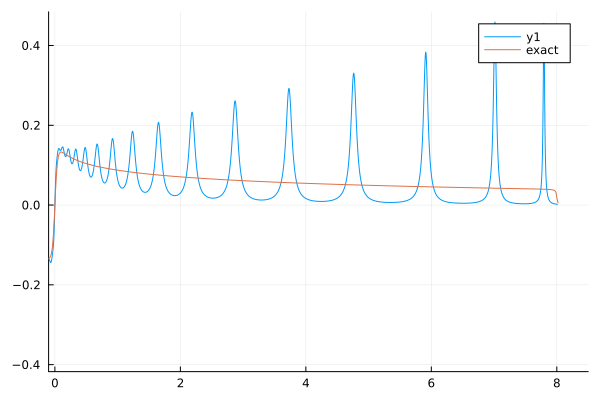

In [31]:
plot(xlim = [-0.1,8.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)- rho.(real.(raw_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

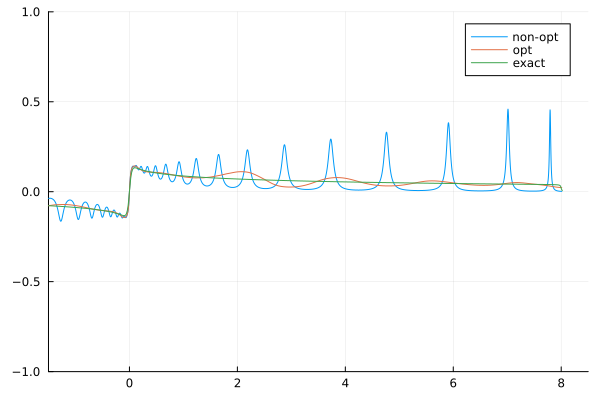

In [32]:
plot(xlim = [-1.5,8.5],ylim= [-1.0,1.0])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
#plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)-rho.(real.(raw_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)-rho.(real.(sol.reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

In [33]:
plot(xlim = [-9,9])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/(pi*scale)),marker=:+)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/(pi*scale))))
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))